In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Load Data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [5]:
from pathlib import Path
downloads_path = str(Path.home() / "Downloads")
downloads_path

'/Users/amankesarwani/Downloads'

In [6]:
img_width, img_height = 100,100

In [7]:
def get_data(s,OUTPUT_CLASS):
    train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)#for validation

    if(OUTPUT_CLASS==10):
        train_data_dir=downloads_path+'/coursera chart type/' 
    else:
        train_data_dir='/content/drive/My Drive/coursera_code/dogs-vs-cats/validation/' 

    train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='categorical',
    subset='training',seed=s) # set as training data

    validation_generator = train_datagen.flow_from_directory(
    train_data_dir,#same train directory
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='categorical',
    subset='validation',seed=s) # set as validation data

    return train_generator,validation_generator

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_accuracy(hist):
  
    figure(figsize=(4, 3), dpi=80)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    # plt.plot(hist.history['loss'])
    # plt.plot(hist.history['val_loss'])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy"])
    plt.show()

    figure(figsize=(4, 3), dpi=80)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Loss","Validation Loss"])
    plt.show()

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import timeit
from keras.models import load_model
def get_k_fold_results(model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"):

    tic = timeit.default_timer()
    df_output = pd.DataFrame(columns=['Loss','Accuracy','F1','Precision','Recall'])
    for i in range(0,k):

        print("=========================================")
        print("====== K Fold Validation step => %d =======" % (i))
        print("=========================================")

        #Getting Data
        train_generator,validation_generator = get_data(i,OUTPUT_CLASS)

        #Adding Dense Layer for Output
        model_intermediate = Flatten()(model_input.output)
        prediction = Dense(OUTPUT_CLASS,activation='softmax')(model_intermediate)
        
#         model_input.add(tf.keras.layers.Dense(OUTPUT_CLASS, activation = 'softmax'))
        model = Model(inputs = model_input.input, outputs = prediction)

        #Compiling Model
        model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=['accuracy',f1_m,precision_m,recall_m])

        #Early Checkpoints
        checkpoint = ModelCheckpoint(modelname, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
        early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

        #Model Fit
        # model.fit_generator(steps_per_epoch=1,generator=train_generator, validation_data=validation_generator, validation_steps=1,epochs=2, callbacks=[checkpoint,early])
        hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
        model.save(modelname)

        #Plot Accuracy
        plot_accuracy(hist)

        #Model Evaluation
        saved_model = load_model(modelname,custom_objects={"f1_m":f1_m,"precision_m":precision_m,"recall_m":recall_m})
        test_score = saved_model.evaluate(validation_generator)
        df_curr = pd.DataFrame(data=[test_score],columns=['Loss','Accuracy','F1','Precision','Recall'])
        display(df_curr)
        df_output = pd.concat([df_curr,df_output])

    toc = timeit.default_timer()
    print(modelname,'Time',toc - tic)
    return df_output.describe()

# TEST

Metal device set to: Apple M2


2022-12-12 20:43:36.001548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 20:43:36.001565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


====== K Fold Validation step => 0 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/2


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-12-12 20:43:36.974211: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/3 [===================>..........] - ETA: 0s - loss: 6.9965 - accuracy: 0.1719 - f1_m: 0.1658 - precision_m: 0.1838 - recall_m: 0.1562

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 485ms/step - loss: 5.9738 - accuracy: 0.3438 - f1_m: 0.3397 - precision_m: 0.3517 - recall_m: 0.3333 - val_loss: 4.3637 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - val_precision_m: 0.7083 - val_recall_m: 0.7083
Epoch 2/2
3/3 [==============================] - 1s 428ms/step - loss: 4.7463 - accuracy: 0.6771 - f1_m: 0.6842 - precision_m: 0.6915 - recall_m: 0.6771 - val_loss: 0.6453 - val_accuracy: 0.8333 - val_f1_m: 0.8333 - val_precision_m: 0.8333 - val_recall_m: 0.8333


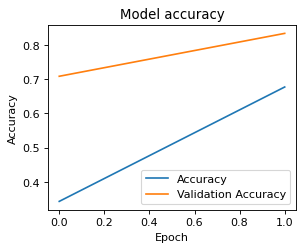

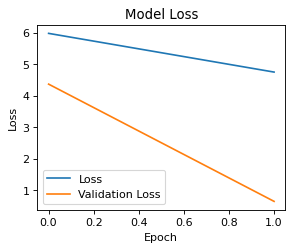

451/451 [==============================] - 29s 64ms/step - loss: 2.6704 - accuracy: 0.7061 - f1_m: 0.7097 - precision_m: 0.7167 - recall_m: 0.7037


,Loss,Accuracy,F1,Precision,Recall
0,2.670361,0.706078,0.709666,0.716688,0.703714


====== K Fold Validation step => 1 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/2


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 447ms/step - loss: 4.9751 - accuracy: 0.3750 - f1_m: 0.3638 - precision_m: 0.4148 - recall_m: 0.3438 - val_loss: 2.3810 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 2/2
3/3 [==============================] - 1s 417ms/step - loss: 1.2515 - accuracy: 0.7812 - f1_m: 0.7812 - precision_m: 0.7812 - recall_m: 0.7812 - val_loss: 0.4477 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision_m: 0.8750 - val_recall_m: 0.8750


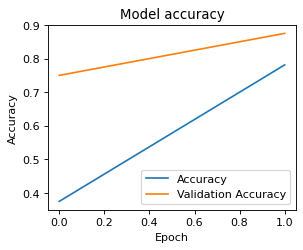

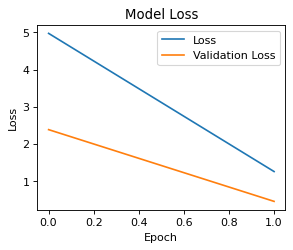

451/451 [==============================] - 27s 60ms/step - loss: 1.1266 - accuracy: 0.8343 - f1_m: 0.8345 - precision_m: 0.8366 - recall_m: 0.8327


,Loss,Accuracy,F1,Precision,Recall
0,1.126557,0.834305,0.834476,0.836567,0.832687


TestFeatureExtractor.h5 Time 65.302451625


,Loss,Accuracy,F1,Precision,Recall
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,1.898459,0.770192,0.772071,0.776627,0.768200
std,1.091634,0.090670,0.088254,0.084767,0.091197
min,1.126557,0.706078,0.709666,0.716688,0.703714
25%,1.512508,0.738135,0.740869,0.746658,0.735957
50%,1.898459,0.770192,0.772071,0.776627,0.768200
75%,2.284410,0.802248,0.803274,0.806597,0.800443
max,2.670361,0.834305,0.834476,0.836567,0.832687


In [9]:
from keras.applications.mobilenet import MobileNet
model_pretrained = MobileNet(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

output = get_k_fold_results(model_pretrained,2,10,2,"TestFeatureExtractor.h5")
output

# VGG 19

## Feature Extractor

====== K Fold Validation step => 0 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/3 [=========>....................] - ETA: 4s - loss: 2.4835 - accuracy: 0.0625 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 7s 2s/step - loss: 2.8327 - accuracy: 0.1979 - f1_m: 0.1957 - precision_m: 0.3532 - recall_m: 0.1354 - val_loss: 1.5528 - val_accuracy: 0.5417 - val_f1_m: 0.4610 - val_precision_m: 0.9333 - val_recall_m: 0.3333
Epoch 2/15
3/3 [==============================] - 7s 2s/step - loss: 1.1612 - accuracy: 0.6354 - f1_m: 0.5395 - precision_m: 0.8067 - recall_m: 0.4062 - val_loss: 1.3503 - val_accuracy: 0.4583 - val_f1_m: 0.4818 - val_precision_m: 0.9167 - val_recall_m: 0.3333
Epoch 3/15
3/3 [==============================] - 7s 2s/step - loss: 0.7972 - accuracy: 0.7917 - f1_m: 0.7490 - precision_m: 0.9881 - recall_m: 0.6250 - val_loss: 0.5895 - val_accuracy: 0.7500 - val_f1_m: 0.7964 - val_precision_m: 0.8552 - val_recall_m: 0.7500
Epoch 4/15
3/3 [==============================] - 7s 2s/step - loss: 0.4398 - accuracy: 0.8438 - f1_m: 0.8442 - precision_m: 0.9352 - recall_m: 0.7708 - val_loss: 0.5467 - val_accuracy: 0.8333 - val_f1_m: 0.7937 - val_precision_

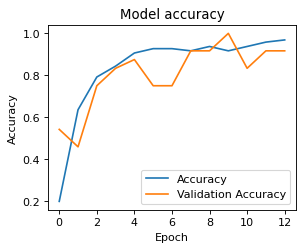

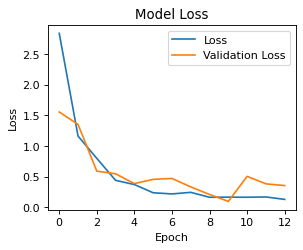

451/451 [==============================] - 72s 160ms/step - loss: 0.3565 - accuracy: 0.8848 - f1_m: 0.8841 - precision_m: 0.9058 - recall_m: 0.8662


,Loss,Accuracy,F1,Precision,Recall
0,0.356524,0.884818,0.884149,0.905805,0.866223


====== K Fold Validation step => 1 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 8s 3s/step - loss: 2.7786 - accuracy: 0.3854 - f1_m: 0.2194 - precision_m: 0.4044 - recall_m: 0.1562 - val_loss: 1.9177 - val_accuracy: 0.5000 - val_f1_m: 0.4690 - val_precision_m: 0.8667 - val_recall_m: 0.3333
Epoch 2/15
3/3 [==============================] - 8s 3s/step - loss: 1.3893 - accuracy: 0.5417 - f1_m: 0.4516 - precision_m: 0.6673 - recall_m: 0.3438 - val_loss: 1.4653 - val_accuracy: 0.4167 - val_f1_m: 0.4269 - val_precision_m: 0.5016 - val_recall_m: 0.3750
Epoch 3/15
3/3 [==============================] - 8s 3s/step - loss: 1.5419 - accuracy: 0.5104 - f1_m: 0.5055 - precision_m: 0.6217 - recall_m: 0.4271 - val_loss: 0.6990 - val_accuracy: 0.7500 - val_f1_m: 0.7492 - val_precision_m: 0.8571 - val_recall_m: 0.6667
Epoch 4/15
3/3 [==============================] - 8s 3s/step - loss: 0.5701 - accuracy: 0.7917 - f1_m: 0.7779 - precision_m: 0.8672 - recall_m: 0.7083 - val_loss: 1.1084 - val_accuracy: 0.6667 - val_f1_m: 0.6123 - val_precision_

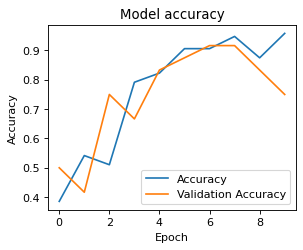

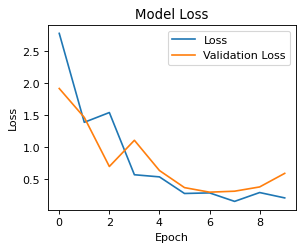

451/451 [==============================] - 85s 188ms/step - loss: 0.4089 - accuracy: 0.8623 - f1_m: 0.8607 - precision_m: 0.8935 - recall_m: 0.8341


,Loss,Accuracy,F1,Precision,Recall
0,0.408862,0.862337,0.860718,0.893499,0.834072


====== K Fold Validation step => 2 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 3.2779 - accuracy: 0.1875 - f1_m: 0.1032 - precision_m: 0.1595 - recall_m: 0.0833 - val_loss: 1.9927 - val_accuracy: 0.5417 - val_f1_m: 0.4861 - val_precision_m: 0.6250 - val_recall_m: 0.4167
Epoch 2/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 1.6548 - accuracy: 0.5521 - f1_m: 0.5424 - precision_m: 0.6553 - recall_m: 0.4688 - val_loss: 1.5073 - val_accuracy: 0.5000 - val_f1_m: 0.4762 - val_precision_m: 0.5556 - val_recall_m: 0.4167
Epoch 3/15
3/3 [==============================] - 9s 3s/step - loss: 1.3004 - accuracy: 0.5938 - f1_m: 0.6099 - precision_m: 0.8088 - recall_m: 0.4896 - val_loss: 1.1987 - val_accuracy: 0.5417 - val_f1_m: 0.5083 - val_precision_m: 0.6012 - val_recall_m: 0.4583
Epoch 4/15
3/3 [==============================] - 8s 3s/step - loss: 0.6932 - accuracy: 0.7500 - f1_m: 0.7892 - precision_m: 0.8464 - recall_m: 0.7396 - val_loss: 0.5445 - val_accuracy: 0.7500 - val_f1_m: 0.7321 - val_precision_m: 0.7639 - val_recall_m: 0.7083
Epoch 5/15
3/3 [==============================] - 8s 3s/step - loss: 0.5321 - accuracy: 0.8125 - f1_m: 0.7810 - precision_m: 0.8412 - recall_m: 0.7292 - val_loss: 0.4979 - val_accuracy: 0.8333 - val_f1_m: 0.8496 - val_precision_

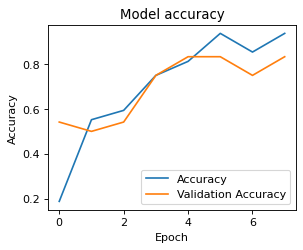

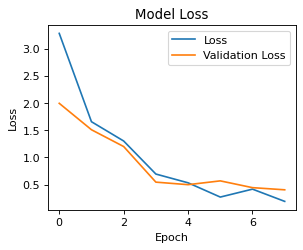

451/451 [==============================] - 81s 179ms/step - loss: 0.4227 - accuracy: 0.8579 - f1_m: 0.8619 - precision_m: 0.9040 - recall_m: 0.8284


,Loss,Accuracy,F1,Precision,Recall
0,0.422671,0.857896,0.861881,0.903963,0.828437


====== K Fold Validation step => 3 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 8s 3s/step - loss: 3.0543 - accuracy: 0.2500 - f1_m: 0.1811 - precision_m: 0.5556 - recall_m: 0.1250 - val_loss: 2.4583 - val_accuracy: 0.3333 - val_f1_m: 0.3114 - val_precision_m: 0.7500 - val_recall_m: 0.2083
Epoch 2/15
3/3 [==============================] - 9s 3s/step - loss: 1.6086 - accuracy: 0.5625 - f1_m: 0.5285 - precision_m: 0.7714 - recall_m: 0.4062 - val_loss: 2.0101 - val_accuracy: 0.2917 - val_f1_m: 0.3248 - val_precision_m: 0.3714 - val_recall_m: 0.2917
Epoch 3/15
3/3 [==============================] - 10s 3s/step - loss: 0.8966 - accuracy: 0.6562 - f1_m: 0.6341 - precision_m: 0.8214 - recall_m: 0.5208 - val_loss: 0.7451 - val_accuracy: 0.7917 - val_f1_m: 0.7738 - val_precision_m: 0.8611 - val_recall_m: 0.7083
Epoch 4/15
3/3 [==============================] - 10s 3s/step - loss: 0.5241 - accuracy: 0.8229 - f1_m: 0.8284 - precision_m: 0.8818 - recall_m: 0.7812 - val_loss: 0.5263 - val_accuracy: 0.7917 - val_f1_m: 0.8056 - val_precisio

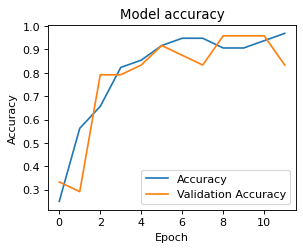

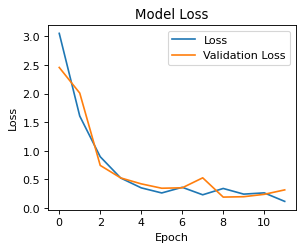

451/451 [==============================] - 81s 178ms/step - loss: 0.4079 - accuracy: 0.8621 - f1_m: 0.8646 - precision_m: 0.8880 - recall_m: 0.8453


,Loss,Accuracy,F1,Precision,Recall
0,0.407927,0.862059,0.864563,0.88804,0.845251


====== K Fold Validation step => 4 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 2.7966 - accuracy: 0.2083 - f1_m: 0.2042 - precision_m: 0.2961 - recall_m: 0.1562 - val_loss: 2.2942 - val_accuracy: 0.2500 - val_f1_m: 0.2904 - val_precision_m: 0.3508 - val_recall_m: 0.2500
Epoch 2/15
3/3 [==============================] - 9s 3s/step - loss: 1.7069 - accuracy: 0.4375 - f1_m: 0.3650 - precision_m: 0.4736 - recall_m: 0.3021 - val_loss: 1.0263 - val_accuracy: 0.5417 - val_f1_m: 0.5458 - val_precision_m: 0.6778 - val_recall_m: 0.4583
Epoch 3/15
3/3 [==============================] - 9s 3s/step - loss: 1.1325 - accuracy: 0.6562 - f1_m: 0.6405 - precision_m: 0.7282 - recall_m: 0.5729 - val_loss: 0.8934 - val_accuracy: 0.6250 - val_f1_m: 0.6774 - val_precision_m: 0.8500 - val_recall_m: 0.5833
Epoch 4/15
3/3 [==============================] - 9s 3s/step - loss: 0.5281 - accuracy: 0.8438 - f1_m: 0.8364 - precision_m: 0.9160 - recall_m: 0.7708 - val_loss: 0.7274 - val_accuracy: 0.7500 - val_f1_m: 0.7238 - val_precision_

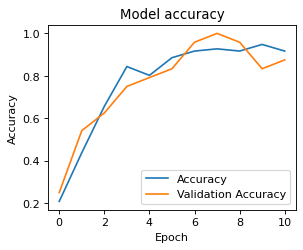

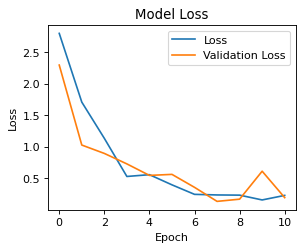

451/451 [==============================] - 82s 182ms/step - loss: 0.3512 - accuracy: 0.8773 - f1_m: 0.8764 - precision_m: 0.8982 - recall_m: 0.8581


,Loss,Accuracy,F1,Precision,Recall
0,0.351214,0.877324,0.876426,0.898155,0.858093


VGG19_FeatureExtractor.h5 Time 861.1915025830001


In [10]:
from keras.applications.vgg19 import VGG19
model_pretrained = VGG19(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

# model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"
output_vgg_f = get_k_fold_results(model_pretrained,15,10,5,"VGG19_FeatureExtractor.h5")

In [11]:
output_vgg_f

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.389440,0.868887,0.869548,0.897892,0.846415
std,0.033045,0.011568,0.010273,0.007347,0.015856
min,0.351214,0.857896,0.860718,0.888040,0.828437
25%,0.356524,0.862059,0.861881,0.893499,0.834072
50%,0.407927,0.862337,0.864563,0.898155,0.845251
75%,0.408862,0.877324,0.876426,0.903963,0.858093
max,0.422671,0.884818,0.884149,0.905805,0.866223


## All Weights Training

====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/3 [=========>....................] - ETA: 2s - loss: 2.6456 - accuracy: 0.1250 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 7.1937 - accuracy: 0.0938 - f1_m: 0.0312 - precision_m: 0.0312 - recall_m: 0.0312 - val_loss: 3.1719 - val_accuracy: 0.0938 - val_f1_m: 0.0938 - val_precision_m: 0.0997 - val_recall_m: 0.0885
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.7232 - accuracy: 0.0839 - f1_m: 0.0328 - precision_m: 0.0345 - recall_m: 0.0312 - val_loss: 2.3313 - val_accuracy: 0.1198 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.3455 - accuracy: 0.1094 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3080 - val_accuracy: 0.0781 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 2.3332 - accuracy: 0.0990 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3250 - val_a

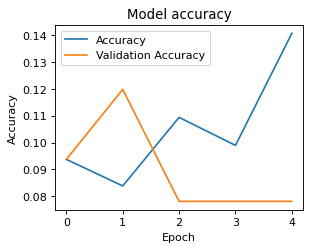

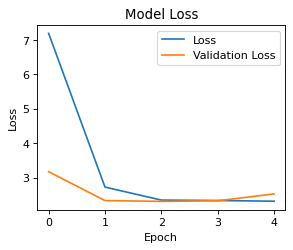

57/57 [==============================] - 14s 240ms/step - loss: 2.5522 - accuracy: 0.0921 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


,Loss,Accuracy,F1,Precision,Recall
0,2.552214,0.092145,0.0,0.0,0.0


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 2.5238 - accuracy: 0.1042 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3307 - val_accuracy: 0.1302 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.3481 - accuracy: 0.1042 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3025 - val_accuracy: 0.0625 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.3070 - accuracy: 0.0990 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3121 - val_accuracy: 0.0677 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 2.2984 - accuracy: 0.1250 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0

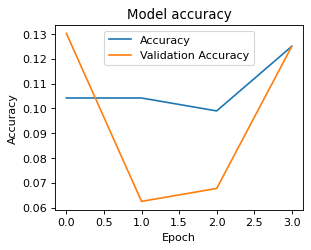

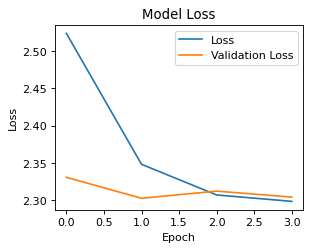

57/57 [==============================] - 14s 235ms/step - loss: 2.3150 - accuracy: 0.1210 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


,Loss,Accuracy,F1,Precision,Recall
0,2.315026,0.12101,0.0,0.0,0.0


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 2.3164 - accuracy: 0.1146 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3481 - val_accuracy: 0.1250 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.3425 - accuracy: 0.0938 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3018 - val_accuracy: 0.1510 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.2978 - accuracy: 0.1042 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.2854 - val_accuracy: 0.1198 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 2.3107 - accuracy: 0.0833 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0

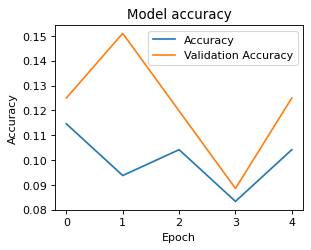

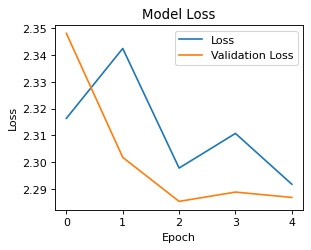

57/57 [==============================] - 14s 238ms/step - loss: 2.2789 - accuracy: 0.1313 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


,Loss,Accuracy,F1,Precision,Recall
0,2.278904,0.131279,0.0,0.0,0.0


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 2.3379 - accuracy: 0.0729 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.2896 - val_accuracy: 0.1771 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.2433 - accuracy: 0.2240 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.1538 - val_accuracy: 0.2656 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.0805 - accuracy: 0.1979 - f1_m: 0.0333 - precision_m: 0.0833 - recall_m: 0.0208 - val_loss: 2.1438 - val_accuracy: 0.2292 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 3s 1s/step - loss: 2.0491 - accuracy: 0.2903 - f1_m: 0.0852 - precision_m: 0.4127 - recall_m: 0.0507 - val_loss: 1.

3/3 [==============================] - 4s 1s/step - loss: 1.5972 - accuracy: 0.4115 - f1_m: 0.3654 - precision_m: 0.6477 - recall_m: 0.2552 - val_loss: 1.8313 - val_accuracy: 0.4115 - val_f1_m: 0.2676 - val_precision_m: 0.7355 - val_recall_m: 0.1667
Epoch 12/200
3/3 [==============================] - 4s 1s/step - loss: 1.6631 - accuracy: 0.3698 - f1_m: 0.2830 - precision_m: 0.6512 - recall_m: 0.1823 - val_loss: 1.9002 - val_accuracy: 0.4323 - val_f1_m: 0.2380 - val_precision_m: 0.7753 - val_recall_m: 0.1406
Epoch 12: early stopping


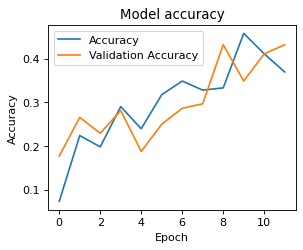

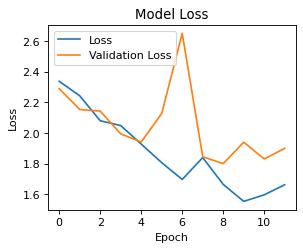

57/57 [==============================] - 14s 248ms/step - loss: 1.7867 - accuracy: 0.4502 - f1_m: 0.2555 - precision_m: 0.7318 - recall_m: 0.1560


,Loss,Accuracy,F1,Precision,Recall
0,1.78673,0.45018,0.255504,0.731778,0.156005


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 2.3832 - accuracy: 0.1562 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9839 - val_accuracy: 0.3385 - val_f1_m: 0.2125 - val_precision_m: 1.0000 - val_recall_m: 0.1198
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.2421 - accuracy: 0.3281 - f1_m: 0.2522 - precision_m: 0.6278 - recall_m: 0.1667 - val_loss: 2.2438 - val_accuracy: 0.1875 - val_f1_m: 0.0486 - val_precision_m: 0.4222 - val_recall_m: 0.0260
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.2082 - accuracy: 0.1510 - f1_m: 0.0196 - precision_m: 0.1667 - recall_m: 0.0104 - val_loss: 2.2228 - val_accuracy: 0.1562 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 2.0236 - accuracy: 0.3021 - f1_m: 0.0103 - precision_m: 0.3333 - recall_m: 0.0052 - val_loss: 1.9758 - val_accuracy: 0.2396 - val_f1

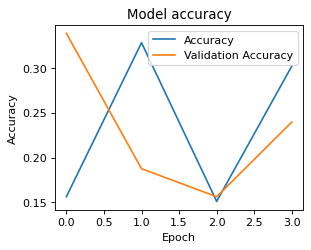

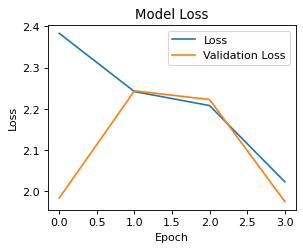

57/57 [==============================] - 15s 250ms/step - loss: 2.0036 - accuracy: 0.2437 - f1_m: 0.2009 - precision_m: 0.8348 - recall_m: 0.1155


,Loss,Accuracy,F1,Precision,Recall
0,2.003631,0.243686,0.200938,0.834822,0.115507


VGG19_All.h5 Time 188.38324670800006


In [13]:
from keras.applications.vgg19 import VGG19
model_h2t = VGG19(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )
for layer in model_h2t.layers:
    layer.trainable = True

output_vgg_all = get_k_fold_results(model_h2t,200,10,5,"VGG19_All.h5")

In [14]:
output_vgg_all

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.187301,0.207660,0.091288,0.313320,0.054302
std,0.296672,0.147309,0.126482,0.430575,0.075722
min,1.786730,0.092145,0.000000,0.000000,0.000000
25%,2.003631,0.121010,0.000000,0.000000,0.000000
50%,2.278904,0.131279,0.000000,0.000000,0.000000
75%,2.315026,0.243686,0.200938,0.731778,0.115507
max,2.552214,0.450180,0.255504,0.834822,0.156005


## Last two layers

0 input_5 -- False
1 block1_conv1 -- False
2 block1_conv2 -- False
3 block1_pool -- False
4 block2_conv1 -- False
5 block2_conv2 -- False
6 block2_pool -- False
7 block3_conv1 -- False
8 block3_conv2 -- False
9 block3_conv3 -- False
10 block3_conv4 -- False
11 block3_pool -- False
12 block4_conv1 -- False
13 block4_conv2 -- False
14 block4_conv3 -- False
15 block4_conv4 -- False
16 block4_pool -- False
17 block5_conv1 -- False
18 block5_conv2 -- False
19 block5_conv3 -- False
20 block5_conv4 -- True
21 block5_pool -- True
====== K Fold Validation step => 0 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 3.1850 - accuracy: 0.3438 - f1_m: 0.2447 - precision_m: 0.3628 - recall_m: 0.1875 - val_loss: 0.8756 - val_accuracy: 0.7500 - val_f1_m: 0.7460 - val_precision_m: 0.9444 - val_recall_m: 0.6250
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.9129 - accuracy: 0.6875 - f1_m: 0.6959 - precision_m: 0.8665 - recall_m: 0.5833

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 0.9129 - accuracy: 0.6875 - f1_m: 0.6959 - precision_m: 0.8665 - recall_m: 0.5833 - val_loss: 1.1030 - val_accuracy: 0.6250 - val_f1_m: 0.5859 - val_precision_m: 1.0000 - val_recall_m: 0.4167
Epoch 3/50
3/3 [==============================] - 11s 4s/step - loss: 0.3432 - accuracy: 0.8646 - f1_m: 0.8670 - precision_m: 0.8923 - recall_m: 0.8438 - val_loss: 0.0762 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/50
3/3 [==============================] - 9s 3s/step - loss: 0.1561 - accuracy: 0.9479 - f1_m: 0.9578 - precision_m: 0.9681 - recall_m: 0.9479 - val_loss: 0.7119 - val_accuracy: 0.7917 - val_f1_m: 0.7611 - val_precision_m: 0.7738 - val_recall_m: 0.7500
Epoch 5/50
3/3 [==============================] - 11s 4s/step - loss: 0.3980 - accuracy: 0.8646 - f1_m: 0.8646 - precision_m: 0.8646 - recall_m: 0.8646 - val_loss: 0.3493 - val_accuracy: 0.9167 - val_f1_m: 0.9167 - val_precisi

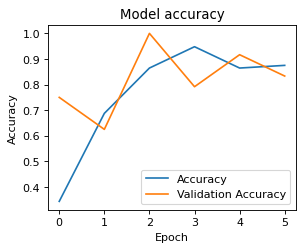

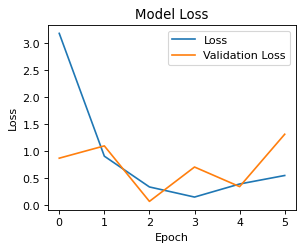

451/451 [==============================] - 370s 822ms/step - loss: 1.0703 - accuracy: 0.8002 - f1_m: 0.8019 - precision_m: 0.8113 - recall_m: 0.7939


,Loss,Accuracy,F1,Precision,Recall
0,1.070256,0.800167,0.801916,0.811319,0.793884


====== K Fold Validation step => 1 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - ETA: 0s - loss: 2.0357 - accuracy: 0.3750 - f1_m: 0.3648 - precision_m: 0.4603 - recall_m: 0.3021

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 8s 3s/step - loss: 2.0357 - accuracy: 0.3750 - f1_m: 0.3648 - precision_m: 0.4603 - recall_m: 0.3021 - val_loss: 0.9366 - val_accuracy: 0.6667 - val_f1_m: 0.6932 - val_precision_m: 0.7944 - val_recall_m: 0.6250
Epoch 2/50
3/3 [==============================] - 308s 152s/step - loss: 0.3091 - accuracy: 0.8854 - f1_m: 0.8941 - precision_m: 0.9149 - recall_m: 0.8750 - val_loss: 0.6242 - val_accuracy: 0.7083 - val_f1_m: 0.7389 - val_precision_m: 0.7738 - val_recall_m: 0.7083
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 0.4751 - accuracy: 0.8125 - f1_m: 0.8258 - precision_m: 0.8517 - recall_m: 0.8021 - val_loss: 0.5161 - val_accuracy: 0.7917 - val_f1_m: 0.8056 - val_precision_m: 0.8214 - val_recall_m: 0.7917
Epoch 4/50
3/3 [==============================] - 8s 3s/step - loss: 0.4368 - accuracy: 0.8854 - f1_m: 0.8826 - precision_m: 0.9014 - recall_m: 0.8646 - val_loss: 0.4721 - val_accuracy: 0.9167 - val_f1_m: 0.8917 - val_preci

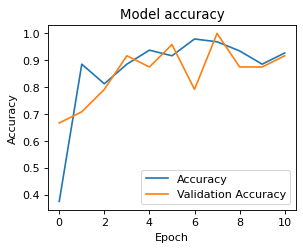

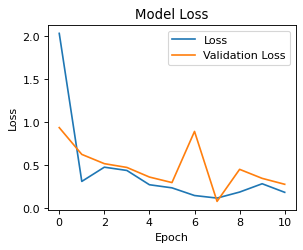

451/451 [==============================] - 337s 749ms/step - loss: 0.2790 - accuracy: 0.9101 - f1_m: 0.9120 - precision_m: 0.9300 - recall_m: 0.8966


,Loss,Accuracy,F1,Precision,Recall
0,0.279009,0.910075,0.911951,0.93005,0.896619


====== K Fold Validation step => 2 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 8s 3s/step - loss: 1.6781 - accuracy: 0.4271 - f1_m: 0.3092 - precision_m: 0.5238 - recall_m: 0.2396 - val_loss: 0.3915 - val_accuracy: 0.9167 - val_f1_m: 0.8667 - val_precision_m: 0.9048 - val_recall_m: 0.8333
Epoch 2/50
1/3 [=========>....................] - ETA: 5s - loss: 0.3556 - accuracy: 0.9062 - f1_m: 0.8966 - precision_m: 1.0000 - recall_m: 0.8125

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 8s 3s/step - loss: 0.2942 - accuracy: 0.9271 - f1_m: 0.9167 - precision_m: 0.9774 - recall_m: 0.8646 - val_loss: 0.7752 - val_accuracy: 0.7500 - val_f1_m: 0.7333 - val_precision_m: 0.7619 - val_recall_m: 0.7083
Epoch 3/50
3/3 [==============================] - 8s 3s/step - loss: 0.1753 - accuracy: 0.9583 - f1_m: 0.9583 - precision_m: 0.9583 - recall_m: 0.9583 - val_loss: 0.0955 - val_accuracy: 0.9583 - val_f1_m: 0.9778 - val_precision_m: 1.0000 - val_recall_m: 0.9583
Epoch 4/50
3/3 [==============================] - 10s 3s/step - loss: 0.0737 - accuracy: 0.9688 - f1_m: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688 - val_loss: 0.6641 - val_accuracy: 0.8333 - val_f1_m: 0.8472 - val_precision_m: 0.8631 - val_recall_m: 0.8333
Epoch 5/50
3/3 [==============================] - 10s 3s/step - loss: 0.2249 - accuracy: 0.9479 - f1_m: 0.9479 - precision_m: 0.9479 - recall_m: 0.9479 - val_loss: 0.3998 - val_accuracy: 0.8333 - val_f1_m: 0.8472 - val_precisio

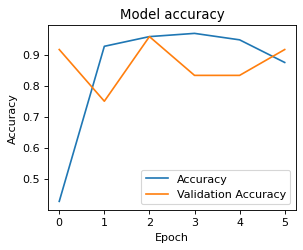

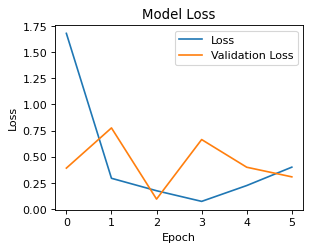

451/451 [==============================] - 80s 177ms/step - loss: 0.2988 - accuracy: 0.9265 - f1_m: 0.9265 - precision_m: 0.9294 - recall_m: 0.9241


,Loss,Accuracy,F1,Precision,Recall
0,0.298846,0.92645,0.926528,0.929442,0.924058


====== K Fold Validation step => 3 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 1.4968 - accuracy: 0.5208 - f1_m: 0.4408 - precision_m: 0.8414 - recall_m: 0.3854 - val_loss: 0.3396 - val_accuracy: 0.9167 - val_f1_m: 0.9361 - val_precision_m: 0.9583 - val_recall_m: 0.9167
Epoch 2/50
3/3 [==============================] - 9s 3s/step - loss: 0.6691 - accuracy: 0.8542 - f1_m: 0.8634 - precision_m: 0.8730 - recall_m: 0.8542 - val_loss: 0.2394 - val_accuracy: 0.9167 - val_f1_m: 0.8944 - val_precision_m: 0.9167 - val_recall_m: 0.8750
Epoch 3/50
3/3 [==============================] - 8s 3s/step - loss: 0.2608 - accuracy: 0.8958 - f1_m: 0.9042 - precision_m: 0.9240 - recall_m: 0.8854 - val_loss: 0.9131 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 4/50
3/3 [==============================] - 9s 3s/step - loss: 0.2376 - accuracy: 0.9271 - f1_m: 0.9153 - precision_m: 0.9250 - recall_m: 0.9062 - val_loss: 0.1300 - val_accuracy: 0.9167 - val_f1_m: 0.9167 - val_precision_

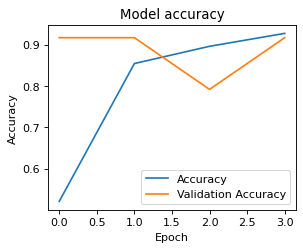

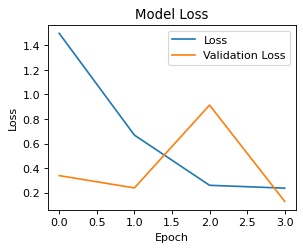

451/451 [==============================] - 82s 183ms/step - loss: 0.3568 - accuracy: 0.8862 - f1_m: 0.8881 - precision_m: 0.9031 - recall_m: 0.8756


,Loss,Accuracy,F1,Precision,Recall
0,0.356799,0.886206,0.888123,0.903052,0.875647


====== K Fold Validation step => 4 =======
Found 14428 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/3 [=========>....................] - ETA: 5s - loss: 2.4372 - accuracy: 0.0938 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 3s/step - loss: 1.4302 - accuracy: 0.5312 - f1_m: 0.4692 - precision_m: 0.5379 - recall_m: 0.4167 - val_loss: 0.5225 - val_accuracy: 0.8750 - val_f1_m: 0.8147 - val_precision_m: 0.9107 - val_recall_m: 0.7500
Epoch 2/50
3/3 [==============================] - 10s 3s/step - loss: 0.2551 - accuracy: 0.8958 - f1_m: 0.9032 - precision_m: 0.9336 - recall_m: 0.8750 - val_loss: 0.2831 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision_m: 0.8750 - val_recall_m: 0.8750
Epoch 3/50
3/3 [==============================] - 9s 3s/step - loss: 0.2203 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167 - val_loss: 0.0652 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/50
3/3 [==============================] - 9s 3s/step - loss: 0.1793 - accuracy: 0.9375 - f1_m: 0.9421 - precision_m: 0.9469 - recall_m: 0.9375 - val_loss: 0.2580 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision

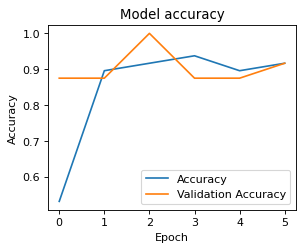

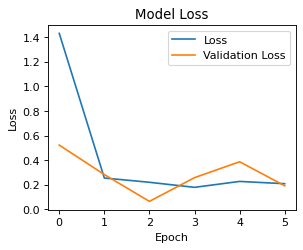

451/451 [==============================] - 81s 179ms/step - loss: 0.3076 - accuracy: 0.9042 - f1_m: 0.9052 - precision_m: 0.9124 - recall_m: 0.8989


,Loss,Accuracy,F1,Precision,Recall
0,0.307601,0.904247,0.905155,0.91243,0.898928


VGG19_FineTune.h5 Time 709.7519373330006


In [15]:
from keras.applications.vgg19 import VGG19
model_last2 = VGG19(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for layer in model_last2.layers[:-2]:
    layer.trainable=False

for i, layer in enumerate(model_last2.layers):
    print(i,layer.name, "--",layer.trainable)

output_vgg_last2 = get_k_fold_results(model_last2,50,10,5,"VGG19_FineTune.h5")

In [16]:
output_vgg_last2

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.462502,0.885429,0.886735,0.897259,0.877827
std,0.340949,0.049786,0.049383,0.049397,0.049967
min,0.279009,0.800167,0.801916,0.811319,0.793884
25%,0.298846,0.886206,0.888123,0.903052,0.875647
50%,0.307601,0.904247,0.905155,0.912430,0.896619
75%,0.356799,0.910075,0.911951,0.929442,0.898928
max,1.070256,0.926450,0.926528,0.930050,0.924058


# MobileNet

## Feature Extractor

====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 491ms/step - loss: 4.4533 - accuracy: 0.3750 - f1_m: 0.3766 - precision_m: 0.4081 - recall_m: 0.3646 - val_loss: 2.4381 - val_accuracy: 0.5833 - val_f1_m: 0.5944 - val_precision_m: 0.6071 - val_recall_m: 0.5833
Epoch 2/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 434ms/step - loss: 1.7173 - accuracy: 0.7812 - f1_m: 0.7851 - precision_m: 0.7890 - recall_m: 0.7812 - val_loss: 2.2595 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - val_precision_m: 0.7083 - val_recall_m: 0.7083
Epoch 3/15
3/3 [==============================] - 1s 422ms/step - loss: 0.8785 - accuracy: 0.8958 - f1_m: 0.8958 - precision_m: 0.8958 - recall_m: 0.8958 - val_loss: 0.7106 - val_accuracy: 0.9583 - val_f1_m: 0.9583 - val_precision_m: 0.9583 - val_recall_m: 0.9583
Epoch 4/15
3/3 [==============================] - 2s 457ms/step - loss: 0.3911 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167 - val_loss: 1.1761 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - val_precision_m: 0.8750 - val_recall_m: 0.8750
Epoch 5/15
3/3 [==============================] - 1s 443ms/step - loss: 0.4890 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167 - val_loss: 1.0583 - val_accuracy: 0.9167 - val_f1_m: 0.9167 - va

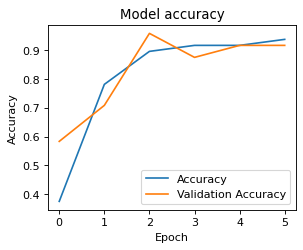

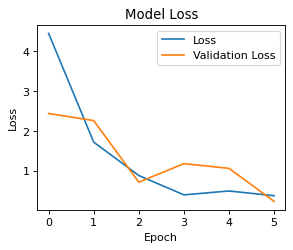

451/451 [==============================] - 27s 61ms/step - loss: 1.4814 - accuracy: 0.8626 - f1_m: 0.8633 - precision_m: 0.8645 - recall_m: 0.8623


,Loss,Accuracy,F1,Precision,Recall
0,1.481439,0.862615,0.863285,0.864468,0.862251


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 457ms/step - loss: 4.6798 - accuracy: 0.4688 - f1_m: 0.4434 - precision_m: 0.4616 - recall_m: 0.4271 - val_loss: 1.7071 - val_accuracy: 0.7083 - val_f1_m: 0.7194 - val_precision_m: 0.7321 - val_recall_m: 0.7083
Epoch 2/15
3/3 [==============================] - 2s 550ms/step - loss: 1.7269 - accuracy: 0.7812 - f1_m: 0.7849 - precision_m: 0.7886 - recall_m: 0.7812 - val_loss: 5.2777 - val_accuracy: 0.6250 - val_f1_m: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6250
Epoch 3/15
3/3 [==============================] - 2s 422ms/step - loss: 2.0437 - accuracy: 0.8125 - f1_m: 0.8125 - precision_m: 0.8125 - recall_m: 0.8125 - val_loss: 2.7995 - val_accuracy: 0.8333 - val_f1_m: 0.8333 - val_precision_m: 0.8333 - val_recall_m: 0.8333
Epoch 4/15
3/3 [==============================] - 1s 431ms/step - loss: 1.1738 - accuracy: 0.8750 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 0.8593 - val_accuracy: 0.8333 - val_f1_m: 0.8333 - va

3/3 [==============================] - 1s 408ms/step - loss: 0.2250 - accuracy: 0.9896 - f1_m: 0.9896 - precision_m: 0.9896 - recall_m: 0.9896 - val_loss: 1.5634 - val_accuracy: 0.8333 - val_f1_m: 0.8333 - val_precision_m: 0.8333 - val_recall_m: 0.8333
Epoch 11: early stopping


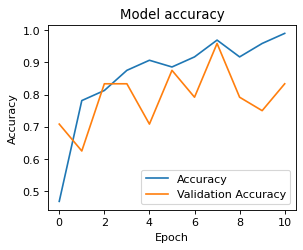

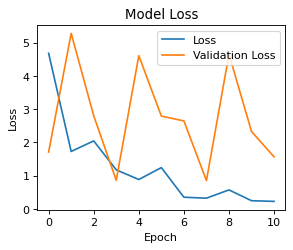

451/451 [==============================] - 27s 61ms/step - loss: 1.4765 - accuracy: 0.8973 - f1_m: 0.8975 - precision_m: 0.8980 - recall_m: 0.8970


,Loss,Accuracy,F1,Precision,Recall
0,1.476549,0.897308,0.897469,0.898018,0.896988


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 543ms/step - loss: 4.7866 - accuracy: 0.3333 - f1_m: 0.3169 - precision_m: 0.3396 - recall_m: 0.3021 - val_loss: 1.6687 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 2/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 438ms/step - loss: 2.4415 - accuracy: 0.6979 - f1_m: 0.7016 - precision_m: 0.7053 - recall_m: 0.6979 - val_loss: 1.6049 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 3/15
3/3 [==============================] - 1s 421ms/step - loss: 0.6896 - accuracy: 0.8854 - f1_m: 0.8854 - precision_m: 0.8854 - recall_m: 0.8854 - val_loss: 1.1381 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - val_precision_m: 0.7083 - val_recall_m: 0.7083
Epoch 4/15
3/3 [==============================] - 1s 424ms/step - loss: 0.2170 - accuracy: 0.9792 - f1_m: 0.9739 - precision_m: 0.9792 - recall_m: 0.9688 - val_loss: 1.9250 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 5/15
3/3 [==============================] - 1s 440ms/step - loss: 1.1832 - accuracy: 0.8750 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 2.3418 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - va

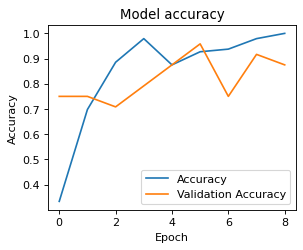

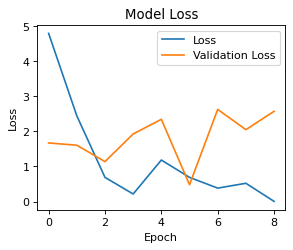

451/451 [==============================] - 27s 61ms/step - loss: 2.1774 - accuracy: 0.8504 - f1_m: 0.8501 - precision_m: 0.8507 - recall_m: 0.8496


,Loss,Accuracy,F1,Precision,Recall
0,2.177436,0.850402,0.850092,0.850663,0.849593


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 477ms/step - loss: 3.9154 - accuracy: 0.4583 - f1_m: 0.4628 - precision_m: 0.4885 - recall_m: 0.4479 - val_loss: 1.0657 - val_accuracy: 0.6667 - val_f1_m: 0.6806 - val_precision_m: 0.6964 - val_recall_m: 0.6667
Epoch 2/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 413ms/step - loss: 0.9132 - accuracy: 0.8542 - f1_m: 0.8480 - precision_m: 0.8525 - recall_m: 0.8438 - val_loss: 1.5325 - val_accuracy: 0.8333 - val_f1_m: 0.8056 - val_precision_m: 0.8214 - val_recall_m: 0.7917
Epoch 3/15
3/3 [==============================] - 1s 396ms/step - loss: 0.7773 - accuracy: 0.8854 - f1_m: 0.8945 - precision_m: 0.9039 - recall_m: 0.8854 - val_loss: 2.6957 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 4/15
3/3 [==============================] - 1s 409ms/step - loss: 1.0636 - accuracy: 0.8854 - f1_m: 0.8854 - precision_m: 0.8854 - recall_m: 0.8854 - val_loss: 0.2146 - val_accuracy: 0.9583 - val_f1_m: 0.9583 - val_precision_m: 0.9583 - val_recall_m: 0.9583
Epoch 5/15
3/3 [==============================] - 1s 426ms/step - loss: 0.1060 - accuracy: 0.9688 - f1_m: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688 - val_loss: 2.3148e-04 - val_accuracy: 1.0000 - val_f1_m: 1.0000 

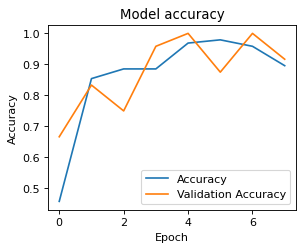

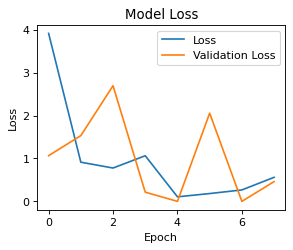

451/451 [==============================] - 27s 60ms/step - loss: 0.4520 - accuracy: 0.9512 - f1_m: 0.9508 - precision_m: 0.9512 - recall_m: 0.9504


,Loss,Accuracy,F1,Precision,Recall
0,0.451963,0.951152,0.950776,0.951219,0.950388


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 461ms/step - loss: 4.5918 - accuracy: 0.4792 - f1_m: 0.4771 - precision_m: 0.4935 - recall_m: 0.4688 - val_loss: 5.7301 - val_accuracy: 0.6667 - val_f1_m: 0.6667 - val_precision_m: 0.6667 - val_recall_m: 0.6667
Epoch 2/15
3/3 [==============================] - 1s 396ms/step - loss: 2.9937 - accuracy: 0.7917 - f1_m: 0.7917 - precision_m: 0.7917 - recall_m: 0.7917 - val_loss: 1.8228 - val_accuracy: 0.7083 - val_f1_m: 0.7250 - val_precision_m: 0.7440 - val_recall_m: 0.7083
Epoch 3/15
1/3 [=========>....................] - ETA: 1s - loss: 2.0003 - accuracy: 0.6875 - f1_m: 0.6875 - precision_m: 0.6875 - recall_m: 0.6875

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 398ms/step - loss: 1.7463 - accuracy: 0.7708 - f1_m: 0.7708 - precision_m: 0.7708 - recall_m: 0.7708 - val_loss: 7.6915 - val_accuracy: 0.7500 - val_f1_m: 0.7167 - val_precision_m: 0.7262 - val_recall_m: 0.7083
Epoch 4/15
3/3 [==============================] - 1s 383ms/step - loss: 1.2244 - accuracy: 0.8750 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 3.4693 - val_accuracy: 0.8750 - val_f1_m: 0.8917 - val_precision_m: 0.9107 - val_recall_m: 0.8750
Epoch 5/15
3/3 [==============================] - 1s 395ms/step - loss: 0.5733 - accuracy: 0.9375 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375 - val_loss: 2.9451 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 6/15
3/3 [==============================] - 1s 392ms/step - loss: 0.7716 - accuracy: 0.9167 - f1_m: 0.9167 - precision_m: 0.9167 - recall_m: 0.9167 - val_loss: 1.9316 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - va

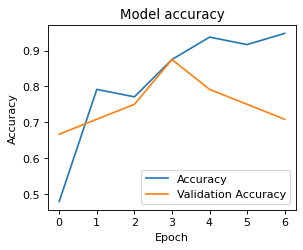

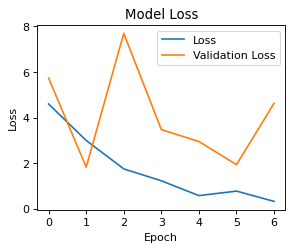

451/451 [==============================] - 27s 61ms/step - loss: 2.6529 - accuracy: 0.8293 - f1_m: 0.8300 - precision_m: 0.8308 - recall_m: 0.8293


,Loss,Accuracy,F1,Precision,Recall
0,2.652879,0.829309,0.829989,0.830813,0.829268


MobileNet_FeatureExtractor.h5 Time 202.2507068750001


In [22]:
from keras.applications.mobilenet import MobileNet
model_pretrained = MobileNet(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

# model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"
output_mobilenet_f = get_k_fold_results(model_pretrained,15,10,5,"MobileNet_FeatureExtractor.h5")

In [23]:
output_mobilenet_f

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.648053,0.878157,0.878322,0.879036,0.877698
std,0.833326,0.047679,0.047369,0.047206,0.047513
min,0.451963,0.829309,0.829989,0.830813,0.829268
25%,1.476549,0.850402,0.850092,0.850663,0.849593
50%,1.481439,0.862615,0.863285,0.864468,0.862251
75%,2.177436,0.897308,0.897469,0.898018,0.896988
max,2.652879,0.951152,0.950776,0.951219,0.950388


## All weights training

Metal device set to: Apple M2


2022-12-14 19:03:53.265785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 19:03:53.265811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-12-14 19:03:54.225929: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/3 [===================>..........] - ETA: 0s - loss: 3.4960 - accuracy: 0.2344 - f1_m: 0.2164 - precision_m: 0.2325 - recall_m: 0.2031

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 911ms/step - loss: 2.4592 - accuracy: 0.4427 - f1_m: 0.4253 - precision_m: 0.4532 - recall_m: 0.4010 - val_loss: 3.2511 - val_accuracy: 0.4167 - val_f1_m: 0.4162 - val_precision_m: 0.4268 - val_recall_m: 0.4062
Epoch 2/200
3/3 [==============================] - 3s 927ms/step - loss: 0.7499 - accuracy: 0.8385 - f1_m: 0.8364 - precision_m: 0.8451 - recall_m: 0.8281 - val_loss: 4.6190 - val_accuracy: 0.5208 - val_f1_m: 0.5260 - val_precision_m: 0.5312 - val_recall_m: 0.5208
Epoch 3/200
3/3 [==============================] - 2s 807ms/step - loss: 0.3464 - accuracy: 0.9115 - f1_m: 0.9140 - precision_m: 0.9166 - recall_m: 0.9115 - val_loss: 6.4825 - val_accuracy: 0.5312 - val_f1_m: 0.5236 - val_precision_m: 0.5264 - val_recall_m: 0.5208
Epoch 4/200
3/3 [==============================] - 2s 916ms/step - loss: 0.5718 - accuracy: 0.8854 - f1_m: 0.8847 - precision_m: 0.8893 - recall_m: 0.8802 - val_loss: 8.3584 - val_accuracy: 0.4792 - val_f1_m: 0.4792 -

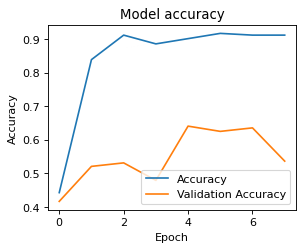

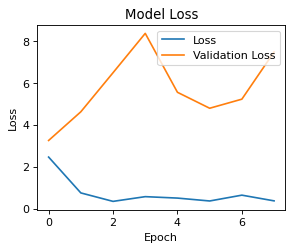

57/57 [==============================] - 13s 222ms/step - loss: 5.6817 - accuracy: 0.5945 - f1_m: 0.5949 - precision_m: 0.5963 - recall_m: 0.5936


,Loss,Accuracy,F1,Precision,Recall
0,5.681656,0.594505,0.594907,0.596252,0.593591


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 944ms/step - loss: 1.9866 - accuracy: 0.5469 - f1_m: 0.5294 - precision_m: 0.5519 - recall_m: 0.5104 - val_loss: 7.6489 - val_accuracy: 0.4062 - val_f1_m: 0.4072 - val_precision_m: 0.4082 - val_recall_m: 0.4062
Epoch 2/200
3/3 [==============================] - 2s 832ms/step - loss: 0.5659 - accuracy: 0.8958 - f1_m: 0.8971 - precision_m: 0.9091 - recall_m: 0.8854 - val_loss: 10.0429 - val_accuracy: 0.3854 - val_f1_m: 0.3864 - val_precision_m: 0.3874 - val_recall_m: 0.3854
Epoch 3/200
3/3 [==============================] - 2s 854ms/step - loss: 0.7108 - accuracy: 0.8854 - f1_m: 0.8850 - precision_m: 0.8899 - recall_m: 0.8802 - val_loss: 11.1717 - val_accuracy: 0.4062 - val_f1_m: 0.4074 - val_precision_m: 0.4085 - val_recall_m: 0.4062
Epoch 4/200
3/3 [==============================] - 2s 835ms/step - loss: 0.4242 - accuracy: 0.9219 - f1_m: 0.9239 - precision_m: 0.9313 - recall_m: 0.9167 - val_loss: 8.6007 - val_accuracy: 0.4167 - val_f1_m: 0.4167

3/3 [==============================] - 2s 880ms/step - loss: 0.3809 - accuracy: 0.9271 - f1_m: 0.9271 - precision_m: 0.9271 - recall_m: 0.9271 - val_loss: 3.8404 - val_accuracy: 0.7135 - val_f1_m: 0.7087 - val_precision_m: 0.7143 - val_recall_m: 0.7031
Epoch 12/200
3/3 [==============================] - 2s 907ms/step - loss: 0.3326 - accuracy: 0.9219 - f1_m: 0.9267 - precision_m: 0.9315 - recall_m: 0.9219 - val_loss: 3.4487 - val_accuracy: 0.7292 - val_f1_m: 0.7346 - val_precision_m: 0.7402 - val_recall_m: 0.7292
Epoch 13/200
3/3 [==============================] - 2s 868ms/step - loss: 0.1989 - accuracy: 0.9375 - f1_m: 0.9396 - precision_m: 0.9471 - recall_m: 0.9323 - val_loss: 4.5956 - val_accuracy: 0.7604 - val_f1_m: 0.7604 - val_precision_m: 0.7604 - val_recall_m: 0.7604
Epoch 13: early stopping


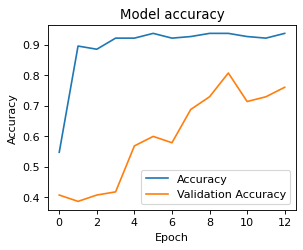

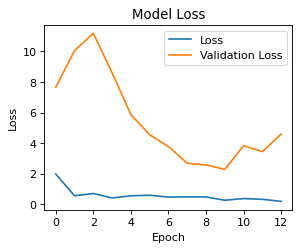

57/57 [==============================] - 13s 221ms/step - loss: 3.7635 - accuracy: 0.7685 - f1_m: 0.7710 - precision_m: 0.7731 - recall_m: 0.7689


,Loss,Accuracy,F1,Precision,Recall
0,3.763485,0.768526,0.770987,0.773128,0.768886


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 961ms/step - loss: 1.8775 - accuracy: 0.6042 - f1_m: 0.6018 - precision_m: 0.6307 - recall_m: 0.5781 - val_loss: 8.4971 - val_accuracy: 0.4792 - val_f1_m: 0.4806 - val_precision_m: 0.4821 - val_recall_m: 0.4792
Epoch 2/200
3/3 [==============================] - 2s 883ms/step - loss: 0.4054 - accuracy: 0.9062 - f1_m: 0.9023 - precision_m: 0.9092 - recall_m: 0.8958 - val_loss: 12.2992 - val_accuracy: 0.4688 - val_f1_m: 0.4701 - val_precision_m: 0.4714 - val_recall_m: 0.4688
Epoch 3/200
3/3 [==============================] - 2s 853ms/step - loss: 0.3240 - accuracy: 0.8958 - f1_m: 0.8948 - precision_m: 0.9044 - recall_m: 0.8854 - val_loss: 9.2670 - val_accuracy: 0.5417 - val_f1_m: 0.5417 - val_precision_m: 0.5417 - val_recall_m: 0.5417
Epoch 4/200
3/3 [==============================] - 2s 834ms/step - loss: 0.5511 - accuracy: 0.8958 - f1_m: 0.9029 - precision_m: 0.9101 - recall_m: 0.8958 - val_loss: 12.1297 - val_accuracy: 0.4948 - val_f1_m: 0.4948

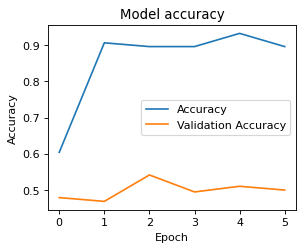

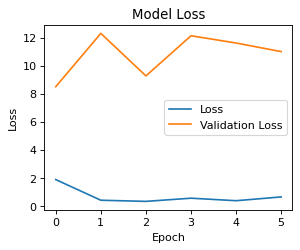

57/57 [==============================] - 13s 220ms/step - loss: 10.5304 - accuracy: 0.4865 - f1_m: 0.4887 - precision_m: 0.4889 - recall_m: 0.4884


,Loss,Accuracy,F1,Precision,Recall
0,10.53036,0.486539,0.488682,0.488938,0.488429


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.6971 - accuracy: 0.6510 - f1_m: 0.6434 - precision_m: 0.7009 - recall_m: 0.5990 - val_loss: 8.0692 - val_accuracy: 0.4531 - val_f1_m: 0.4531 - val_precision_m: 0.4531 - val_recall_m: 0.4531
Epoch 2/200
3/3 [==============================] - 2s 838ms/step - loss: 0.2447 - accuracy: 0.9427 - f1_m: 0.9425 - precision_m: 0.9475 - recall_m: 0.9375 - val_loss: 9.8965 - val_accuracy: 0.4635 - val_f1_m: 0.4649 - val_precision_m: 0.4663 - val_recall_m: 0.4635
Epoch 3/200
3/3 [==============================] - 2s 855ms/step - loss: 0.3598 - accuracy: 0.9479 - f1_m: 0.9451 - precision_m: 0.9476 - recall_m: 0.9427 - val_loss: 15.9004 - val_accuracy: 0.4635 - val_f1_m: 0.4635 - val_precision_m: 0.4635 - val_recall_m: 0.4635
Epoch 4/200
3/3 [==============================] - 2s 852ms/step - loss: 0.3189 - accuracy: 0.9271 - f1_m: 0.9321 - precision_m: 0.9373 - recall_m: 0.9271 - val_loss: 13.8959 - val_accuracy: 0.5260 - val_f1_m: 0.5260 - 

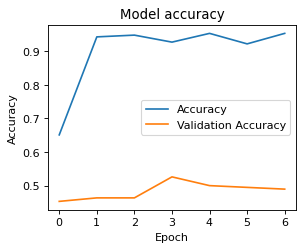

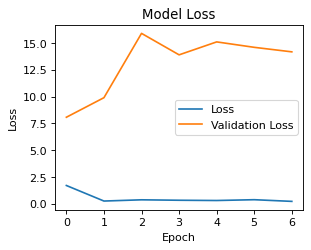

57/57 [==============================] - 13s 222ms/step - loss: 13.2769 - accuracy: 0.4752 - f1_m: 0.4758 - precision_m: 0.4762 - recall_m: 0.4755


,Loss,Accuracy,F1,Precision,Recall
0,13.276883,0.47516,0.475844,0.476178,0.475516


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 979ms/step - loss: 1.3958 - accuracy: 0.6250 - f1_m: 0.6232 - precision_m: 0.6831 - recall_m: 0.5885 - val_loss: 8.5308 - val_accuracy: 0.4896 - val_f1_m: 0.4921 - val_precision_m: 0.4946 - val_recall_m: 0.4896
Epoch 2/200
3/3 [==============================] - 2s 878ms/step - loss: 0.3432 - accuracy: 0.9271 - f1_m: 0.9313 - precision_m: 0.9466 - recall_m: 0.9167 - val_loss: 10.5341 - val_accuracy: 0.5156 - val_f1_m: 0.5184 - val_precision_m: 0.5212 - val_recall_m: 0.5156
Epoch 3/200
3/3 [==============================] - 2s 831ms/step - loss: 0.4501 - accuracy: 0.9375 - f1_m: 0.9400 - precision_m: 0.9425 - recall_m: 0.9375 - val_loss: 9.2844 - val_accuracy: 0.5208 - val_f1_m: 0.5208 - val_precision_m: 0.5208 - val_recall_m: 0.5208
Epoch 4/200
3/3 [==============================] - 2s 833ms/step - loss: 0.2212 - accuracy: 0.9427 - f1_m: 0.9373 - precision_m: 0.9424 - recall_m: 0.9323 - val_loss: 9.7982 - val_accuracy: 0.4583 - val_f1_m: 0.4551 

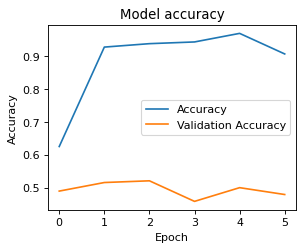

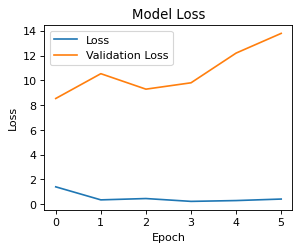

57/57 [==============================] - 13s 221ms/step - loss: 14.3545 - accuracy: 0.4455 - f1_m: 0.4455 - precision_m: 0.4464 - recall_m: 0.4446


,Loss,Accuracy,F1,Precision,Recall
0,14.354527,0.445462,0.445483,0.446373,0.444613


MobileNet_All.h5 Time 170.921707291


In [10]:
from keras.applications.mobilenet import MobileNet
model_h2t = MobileNet(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )
for layer in model_h2t.layers:
    layer.trainable = True

output_mobilenet_all = get_k_fold_results(model_h2t,200,10,5,"MobileNet_All.h5")

In [11]:
output_mobilenet_all

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,9.521382,0.554038,0.555180,0.556174,0.554207
std,4.646988,0.132485,0.133136,0.133839,0.132446
min,3.763485,0.445462,0.445483,0.446373,0.444613
25%,5.681656,0.475160,0.475844,0.476178,0.475516
50%,10.530360,0.486539,0.488682,0.488938,0.488429
75%,13.276883,0.594505,0.594907,0.596252,0.593591
max,14.354527,0.768526,0.770987,0.773128,0.768886


## Last two layers fine tune

0 input_11 -- False
1 conv1 -- False
2 conv1_bn -- False
3 conv1_relu -- False
4 conv_dw_1 -- False
5 conv_dw_1_bn -- False
6 conv_dw_1_relu -- False
7 conv_pw_1 -- False
8 conv_pw_1_bn -- False
9 conv_pw_1_relu -- False
10 conv_pad_2 -- False
11 conv_dw_2 -- False
12 conv_dw_2_bn -- False
13 conv_dw_2_relu -- False
14 conv_pw_2 -- False
15 conv_pw_2_bn -- False
16 conv_pw_2_relu -- False
17 conv_dw_3 -- False
18 conv_dw_3_bn -- False
19 conv_dw_3_relu -- False
20 conv_pw_3 -- False
21 conv_pw_3_bn -- False
22 conv_pw_3_relu -- False
23 conv_pad_4 -- False
24 conv_dw_4 -- False
25 conv_dw_4_bn -- False
26 conv_dw_4_relu -- False
27 conv_pw_4 -- False
28 conv_pw_4_bn -- False
29 conv_pw_4_relu -- False
30 conv_dw_5 -- False
31 conv_dw_5_bn -- False
32 conv_dw_5_relu -- False
33 conv_pw_5 -- False
34 conv_pw_5_bn -- False
35 conv_pw_5_relu -- False
36 conv_pad_6 -- False
37 conv_dw_6 -- False
38 conv_dw_6_bn -- False
39 conv_dw_6_relu -- False
40 conv_pw_6 -- False
41 conv_pw_6_bn -- Fal

/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/3 [===================>..........] - ETA: 0s - loss: 9.7807 - accuracy: 0.1406 - f1_m: 0.1496 - precision_m: 0.1629 - recall_m: 0.1406

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 479ms/step - loss: 7.6254 - accuracy: 0.3333 - f1_m: 0.3393 - precision_m: 0.3482 - recall_m: 0.3333 - val_loss: 0.9868 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 2/50
3/3 [==============================] - 1s 434ms/step - loss: 2.6753 - accuracy: 0.7812 - f1_m: 0.7892 - precision_m: 0.7974 - recall_m: 0.7812 - val_loss: 0.8779 - val_accuracy: 0.8333 - val_f1_m: 0.8472 - val_precision_m: 0.8631 - val_recall_m: 0.8333
Epoch 3/50
3/3 [==============================] - 1s 429ms/step - loss: 1.0104 - accuracy: 0.8438 - f1_m: 0.8482 - precision_m: 0.8528 - recall_m: 0.8438 - val_loss: 0.9005 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 4/50
3/3 [==============================] - 1s 426ms/step - loss: 0.7637 - accuracy: 0.9375 - f1_m: 0.9375 - precision_m: 0.9375 - recall_m: 0.9375 - val_loss: 0.7347 - val_accuracy: 0.9167 - val_f1_m: 0.9167 - va

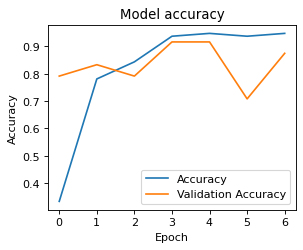

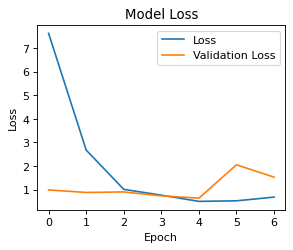

451/451 [==============================] - 28s 61ms/step - loss: 1.2034 - accuracy: 0.8776 - f1_m: 0.8777 - precision_m: 0.8782 - recall_m: 0.8772


,Loss,Accuracy,F1,Precision,Recall
0,1.203399,0.877602,0.877679,0.878207,0.877217


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 435ms/step - loss: 7.2711 - accuracy: 0.3021 - f1_m: 0.2946 - precision_m: 0.2986 - recall_m: 0.2917 - val_loss: 6.1492 - val_accuracy: 0.5833 - val_f1_m: 0.5833 - val_precision_m: 0.5833 - val_recall_m: 0.5833
Epoch 2/50
3/3 [==============================] - 1s 407ms/step - loss: 4.5143 - accuracy: 0.6875 - f1_m: 0.6905 - precision_m: 0.6935 - recall_m: 0.6875 - val_loss: 1.1000 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 3/50
3/3 [==============================] - 1s 391ms/step - loss: 0.5752 - accuracy: 0.9375 - f1_m: 0.9425 - precision_m: 0.9476 - recall_m: 0.9375 - val_loss: 3.1675 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 4/50
3/3 [==============================] - 1s 385ms/step - loss: 2.8147 - accuracy: 0.7917 - f1_m: 0.7917 - precision_m: 0.7917 - recall_m: 0.7917 - val_loss: 1.1620 - val_accuracy: 0.9167 - val_f1_m: 0.9167 - va

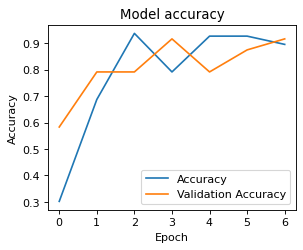

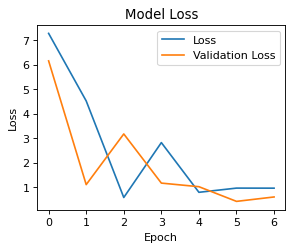

451/451 [==============================] - 27s 60ms/step - loss: 0.7739 - accuracy: 0.9148 - f1_m: 0.9156 - precision_m: 0.9167 - recall_m: 0.9146


,Loss,Accuracy,F1,Precision,Recall
0,0.773863,0.914793,0.915595,0.916693,0.914634


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 2s 443ms/step - loss: 7.1989 - accuracy: 0.3125 - f1_m: 0.2858 - precision_m: 0.2919 - recall_m: 0.2812 - val_loss: 2.0553 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - val_precision_m: 0.7083 - val_recall_m: 0.7083
Epoch 2/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 424ms/step - loss: 2.1765 - accuracy: 0.8333 - f1_m: 0.8333 - precision_m: 0.8333 - recall_m: 0.8333 - val_loss: 2.4745 - val_accuracy: 0.6667 - val_f1_m: 0.6833 - val_precision_m: 0.7024 - val_recall_m: 0.6667
Epoch 3/50
3/3 [==============================] - 2s 512ms/step - loss: 1.3460 - accuracy: 0.8958 - f1_m: 0.8958 - precision_m: 0.8958 - recall_m: 0.8958 - val_loss: 1.6875 - val_accuracy: 0.7917 - val_f1_m: 0.7917 - val_precision_m: 0.7917 - val_recall_m: 0.7917
Epoch 4/50
3/3 [==============================] - 1s 389ms/step - loss: 0.7959 - accuracy: 0.9062 - f1_m: 0.9062 - precision_m: 0.9062 - recall_m: 0.9062 - val_loss: 0.0029 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 5/50
3/3 [==============================] - 1s 492ms/step - loss: 0.8912 - accuracy: 0.9479 - f1_m: 0.9479 - precision_m: 0.9479 - recall_m: 0.9479 - val_loss: 0.9076 - val_accuracy: 0.8750 - val_f1_m: 0.8750 - va

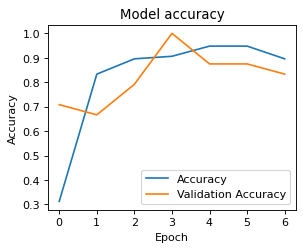

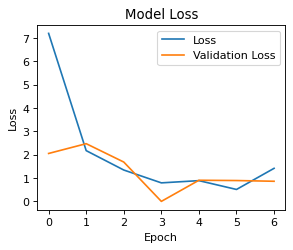

451/451 [==============================] - 27s 60ms/step - loss: 0.8816 - accuracy: 0.9206 - f1_m: 0.9208 - precision_m: 0.9213 - recall_m: 0.9203


,Loss,Accuracy,F1,Precision,Recall
0,0.881572,0.920622,0.920769,0.921339,0.92027


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - ETA: 0s - loss: 10.5573 - accuracy: 0.3125 - f1_m: 0.3206 - precision_m: 0.3314 - recall_m: 0.3125

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 485ms/step - loss: 10.5573 - accuracy: 0.3125 - f1_m: 0.3206 - precision_m: 0.3314 - recall_m: 0.3125 - val_loss: 8.1592 - val_accuracy: 0.5833 - val_f1_m: 0.5833 - val_precision_m: 0.5833 - val_recall_m: 0.5833
Epoch 2/50
3/3 [==============================] - 1s 400ms/step - loss: 5.7580 - accuracy: 0.7188 - f1_m: 0.7224 - precision_m: 0.7261 - recall_m: 0.7188 - val_loss: 1.7152 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 3/50
3/3 [==============================] - 1s 410ms/step - loss: 1.9384 - accuracy: 0.7917 - f1_m: 0.7917 - precision_m: 0.7917 - recall_m: 0.7917 - val_loss: 3.0551 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 4/50
3/3 [==============================] - 1s 390ms/step - loss: 2.0825 - accuracy: 0.8750 - f1_m: 0.8750 - precision_m: 0.8750 - recall_m: 0.8750 - val_loss: 1.7964 - val_accuracy: 0.7083 - val_f1_m: 0.7083 - v

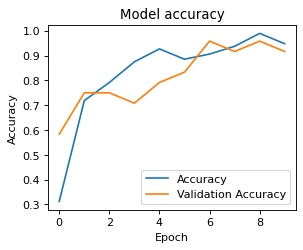

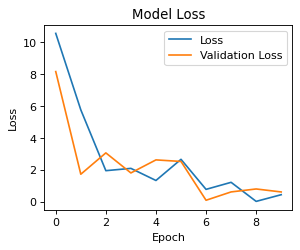

451/451 [==============================] - 28s 62ms/step - loss: 1.5009 - accuracy: 0.9017 - f1_m: 0.9014 - precision_m: 0.9014 - recall_m: 0.9014


,Loss,Accuracy,F1,Precision,Recall
0,1.500931,0.901749,0.901423,0.901423,0.901423


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_96643/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 470ms/step - loss: 3.9575 - accuracy: 0.4792 - f1_m: 0.4746 - precision_m: 0.4850 - recall_m: 0.4688 - val_loss: 4.3173 - val_accuracy: 0.5417 - val_f1_m: 0.5417 - val_precision_m: 0.5417 - val_recall_m: 0.5417
Epoch 2/50
3/3 [==============================] - 1s 389ms/step - loss: 3.5589 - accuracy: 0.6875 - f1_m: 0.6806 - precision_m: 0.6841 - recall_m: 0.6771 - val_loss: 2.1979 - val_accuracy: 0.7083 - val_f1_m: 0.7194 - val_precision_m: 0.7321 - val_recall_m: 0.7083
Epoch 3/50
3/3 [==============================] - 1s 409ms/step - loss: 1.6716 - accuracy: 0.8438 - f1_m: 0.8438 - precision_m: 0.8438 - recall_m: 0.8438 - val_loss: 2.8141 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 4/50
3/3 [==============================] - 1s 387ms/step - loss: 1.4357 - accuracy: 0.8438 - f1_m: 0.8484 - precision_m: 0.8532 - recall_m: 0.8438 - val_loss: 5.4928 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - va

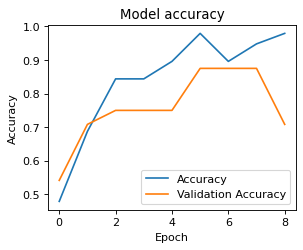

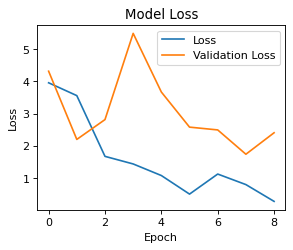

451/451 [==============================] - 27s 60ms/step - loss: 1.1245 - accuracy: 0.9073 - f1_m: 0.9076 - precision_m: 0.9087 - recall_m: 0.9066


,Loss,Accuracy,F1,Precision,Recall
0,1.124473,0.9073,0.907557,0.908655,0.906596


MobileNet_FineTune.h5 Time 200.2451755000002


In [24]:
from keras.applications.mobilenet import MobileNet
model_last2 = MobileNet(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for layer in model_last2.layers[:-2]:
    layer.trainable=False

for i, layer in enumerate(model_last2.layers):
    print(i,layer.name, "--",layer.trainable)

output_mobilenet_last2 = get_k_fold_results(model_last2,50,10,5,"MobileNet_FineTune.h5")

In [25]:
output_mobilenet_last2

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.096848,0.904413,0.904605,0.905263,0.904028
std,0.285509,0.016619,0.016777,0.016936,0.016647
min,0.773863,0.877602,0.877679,0.878207,0.877217
25%,0.881572,0.901749,0.901423,0.901423,0.901423
50%,1.124473,0.907300,0.907557,0.908655,0.906596
75%,1.203399,0.914793,0.915595,0.916693,0.914634
max,1.500931,0.920622,0.920769,0.921339,0.920270


# Inception

## Feature Extractor

In [12]:
from keras.applications.inception_v3 import InceptionV3
model_pretrained = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

# model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"
output_inc3_f = get_k_fold_results(model_pretrained,15,10,5,"InceptionV3_FeatureExtractor.h5")



====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7017/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


2022-12-14 18:47:18.074346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 18:47:18.777006: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x13a095c40
2022-12-14 18:47:18.777033: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x13a095c40


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7017/1835666954.py", line 8, in <module>
      output_inc3_f = get_k_fold_results(model_pretrained,15,10,5,"InceptionV3_FeatureExtractor.h5")
    File "/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7017/1867010446.py", line 34, in get_k_fold_results
      hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 2604, in fit_generator
      return self.fit(
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall'
could not find registered platform with id: 0x13a095c40
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_train_function_25405]

In [ ]:
output_inc3_f

## All weights training

In [ ]:
from tensorflow.keras.applications import InceptionV3
model_h2t = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )
for layer in model_h2t.layers:
    layer.trainable = True

output_inc3_all = get_k_fold_results(model_h2t,200,10,5,"InceptionV3_All.h5")

In [ ]:
output_inc3_all

## Last two layers fine tune

In [ ]:
# from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import InceptionV3

model_last2 = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for layer in model_last2.layers[:-2]:
    layer.trainable=False

for i, layer in enumerate(model_last2.layers):
    print(i,layer.name, "--",layer.trainable)

output_inc3_last2 = get_k_fold_results(model_last2,50,10,5,"InceptionV3_FineTune.h5")

Metal device set to: Apple M2


2022-12-14 18:24:54.144606: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 18:24:54.144659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0 input_1 -- False
1 conv2d -- False
2 batch_normalization -- False
3 activation -- False
4 conv2d_1 -- False
5 batch_normalization_1 -- False
6 activation_1 -- False
7 conv2d_2 -- False
8 batch_normalization_2 -- False
9 activation_2 -- False
10 max_pooling2d -- False
11 conv2d_3 -- False
12 batch_normalization_3 -- False
13 activation_3 -- False
14 conv2d_4 -- False
15 batch_normalization_4 -- False
16 activation_4 -- False
17 max_pooling2d_1 -- False
18 conv2d_8 -- False
19 batch_normalization_8 -- False
20 activation_8 -- False
21 conv2d_6 -- False
22 conv2d_9 -- False
23 batch_normalization_6 -- False
24 batch_normalization_9 -- False
25 activation_6 -- False
26 activation_9 -- False
27 average_pooling2d -- False
28 conv2d_5 -- False
29 conv2d_7 -- False
30 conv2d_10 -- False
31 conv2d_11 -- False
32 batch_normalization_5 -- False
33 batch_normalization_7 -- False
34 batch_normalization_10 -- False
35 batch_normalization_11 -- False
36 activation_5 -- False
37 activation_7 -- Fals

Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7005/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-12-14 18:24:55.943737: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
output_inc3_last2

# Resnet 152

## Feature Extractor

====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 7s 3s/step - loss: 5.5422 - accuracy: 0.2031 - f1_m: 0.0643 - precision_m: 0.5333 - recall_m: 0.0365 - val_loss: 8.1842 - val_accuracy: 0.1562 - val_f1_m: 0.1319 - val_precision_m: 0.1978 - val_recall_m: 0.0990
Epoch 2/15
3/3 [==============================] - 6s 2s/step - loss: 9.7954 - accuracy: 0.1719 - f1_m: 0.1672 - precision_m: 0.2099 - recall_m: 0.1458 - val_loss: 10.3251 - val_accuracy: 0.1146 - val_f1_m: 0.1148 - val_precision_m: 0.1151 - val_recall_m: 0.1146
Epoch 3/15
3/3 [==============================] - 6s 2s/step - loss: 8.3771 - accuracy: 0.1354 - f1_m: 0.1354 - precision_m: 0.1354 - recall_m: 0.1354 - val_loss: 7.8597 - val_accuracy: 0.1146 - val_f1_m: 0.1115 - val_precision_m: 0.1378 - val_recall_m: 0.0938
Epoch 4/15
3/3 [==============================] - 6s 2s/step - loss: 6.1309 - accuracy: 0.1771 - f1_m: 0.1762 - precision_m: 0.1871 - recall_m: 0.1667 - val_loss: 3.7122 - val_accuracy: 0.2083 - val_f1_m: 0.1808 - val_precision

3/3 [==============================] - 5s 2s/step - loss: 2.5547 - accuracy: 0.2708 - f1_m: 0.2740 - precision_m: 0.4638 - recall_m: 0.1979 - val_loss: 2.4700 - val_accuracy: 0.2396 - val_f1_m: 0.2397 - val_precision_m: 0.2652 - val_recall_m: 0.2188
Epoch 12/15
3/3 [==============================] - 5s 2s/step - loss: 1.8452 - accuracy: 0.4010 - f1_m: 0.2893 - precision_m: 0.5937 - recall_m: 0.2083 - val_loss: 2.2289 - val_accuracy: 0.2969 - val_f1_m: 0.2298 - val_precision_m: 0.4455 - val_recall_m: 0.1562
Epoch 12: early stopping


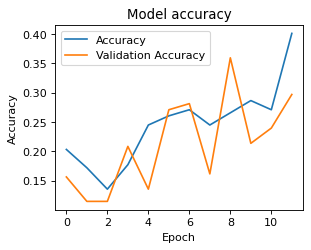

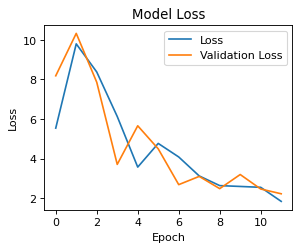

57/57 [==============================] - 19s 328ms/step - loss: 2.1858 - accuracy: 0.3200 - f1_m: 0.2307 - precision_m: 0.4530 - recall_m: 0.1556


,Loss,Accuracy,F1,Precision,Recall
0,2.185834,0.320011,0.230679,0.453046,0.15563


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 7.3355 - accuracy: 0.1250 - f1_m: 0.0262 - precision_m: 0.0265 - recall_m: 0.0260 - val_loss: 10.4401 - val_accuracy: 0.0781 - val_f1_m: 0.0781 - val_precision_m: 0.0781 - val_recall_m: 0.0781
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 10.1370 - accuracy: 0.1198 - f1_m: 0.1179 - precision_m: 0.1216 - recall_m: 0.1146 - val_loss: 8.7164 - val_accuracy: 0.2292 - val_f1_m: 0.2105 - val_precision_m: 0.4274 - val_recall_m: 0.1406
Epoch 3/15
3/3 [==============================] - 5s 2s/step - loss: 8.1673 - accuracy: 0.2552 - f1_m: 0.2489 - precision_m: 0.3333 - recall_m: 0.2188 - val_loss: 5.8072 - val_accuracy: 0.2292 - val_f1_m: 0.2210 - val_precision_m: 0.3101 - val_recall_m: 0.1719
Epoch 4/15
3/3 [==============================] - 5s 2s/step - loss: 8.5357 - accuracy: 0.1875 - f1_m: 0.1803 - precision_m: 0.2399 - recall_m: 0.1562 - val_loss: 7.6750 - val_accuracy: 0.2031 - val_f1_m: 0.2057 - val_precisio

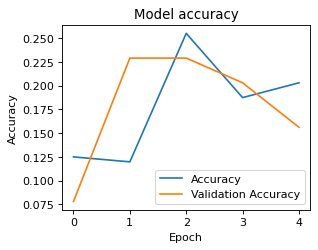

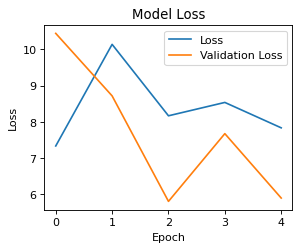

57/57 [==============================] - 20s 337ms/step - loss: 5.7677 - accuracy: 0.1854 - f1_m: 0.1601 - precision_m: 0.2264 - recall_m: 0.1245


,Loss,Accuracy,F1,Precision,Recall
0,5.767728,0.185401,0.160063,0.226372,0.124452


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 6.4716 - accuracy: 0.1615 - f1_m: 0.0971 - precision_m: 0.1528 - recall_m: 0.0729 - val_loss: 12.2599 - val_accuracy: 0.0938 - val_f1_m: 0.0943 - val_precision_m: 0.0948 - val_recall_m: 0.0938
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 12.0389 - accuracy: 0.0469 - f1_m: 0.0469 - precision_m: 0.0469 - recall_m: 0.0469 - val_loss: 9.6723 - val_accuracy: 0.1354 - val_f1_m: 0.1366 - val_precision_m: 0.1507 - val_recall_m: 0.1250
Epoch 3/15
3/3 [==============================] - 5s 2s/step - loss: 10.3915 - accuracy: 0.1562 - f1_m: 0.1580 - precision_m: 0.1600 - recall_m: 0.1562 - val_loss: 10.7952 - val_accuracy: 0.2083 - val_f1_m: 0.2089 - val_precision_m: 0.2095 - val_recall_m: 0.2083
Epoch 4/15
3/3 [==============================] - 5s 2s/step - loss: 9.9842 - accuracy: 0.2240 - f1_m: 0.2260 - precision_m: 0.2281 - recall_m: 0.2240 - val_loss: 5.0801 - val_accuracy: 0.1927 - val_f1_m: 0.2010 - val_precis

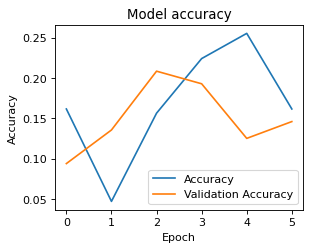

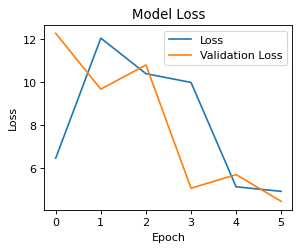

57/57 [==============================] - 20s 343ms/step - loss: 4.8186 - accuracy: 0.1238 - f1_m: 0.1241 - precision_m: 0.1280 - recall_m: 0.1205


,Loss,Accuracy,F1,Precision,Recall
0,4.818569,0.123786,0.12412,0.128044,0.12047


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 7.1711 - accuracy: 0.1094 - f1_m: 0.0735 - precision_m: 0.1135 - recall_m: 0.0677 - val_loss: 10.9549 - val_accuracy: 0.0625 - val_f1_m: 0.0625 - val_precision_m: 0.0625 - val_recall_m: 0.0625
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 10.0688 - accuracy: 0.0990 - f1_m: 0.0983 - precision_m: 0.1131 - recall_m: 0.0885 - val_loss: 11.2581 - val_accuracy: 0.0938 - val_f1_m: 0.0937 - val_precision_m: 0.0938 - val_recall_m: 0.0938
Epoch 3/15
3/3 [==============================] - 5s 2s/step - loss: 9.9507 - accuracy: 0.0990 - f1_m: 0.0683 - precision_m: 0.1153 - recall_m: 0.0573 - val_loss: 8.0312 - val_accuracy: 0.1354 - val_f1_m: 0.1354 - val_precision_m: 0.1354 - val_recall_m: 0.1354
Epoch 4/15
3/3 [==============================] - 5s 2s/step - loss: 6.4660 - accuracy: 0.1771 - f1_m: 0.1666 - precision_m: 0.2027 - recall_m: 0.1458 - val_loss: 5.9092 - val_accuracy: 0.1719 - val_f1_m: 0.1730 - val_precisi

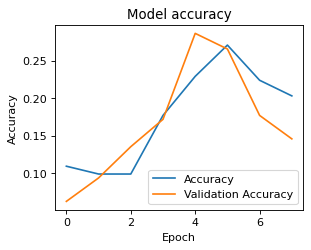

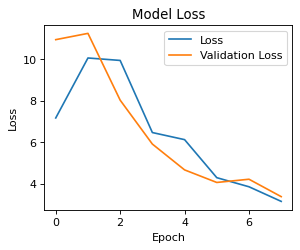

57/57 [==============================] - 19s 332ms/step - loss: 3.4666 - accuracy: 0.1848 - f1_m: 0.1894 - precision_m: 0.2139 - recall_m: 0.1704


,Loss,Accuracy,F1,Precision,Recall
0,3.466574,0.184846,0.189439,0.213875,0.17036


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 7s 2s/step - loss: 6.3775 - accuracy: 0.1354 - f1_m: 0.1201 - precision_m: 0.1265 - recall_m: 0.1146 - val_loss: 9.4449 - val_accuracy: 0.0885 - val_f1_m: 0.0885 - val_precision_m: 0.0885 - val_recall_m: 0.0885
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 8.0977 - accuracy: 0.1094 - f1_m: 0.1094 - precision_m: 0.1094 - recall_m: 0.1094 - val_loss: 13.1243 - val_accuracy: 0.0677 - val_f1_m: 0.0627 - val_precision_m: 0.0628 - val_recall_m: 0.0625
Epoch 3/15
3/3 [==============================] - 5s 2s/step - loss: 13.8292 - accuracy: 0.1146 - f1_m: 0.1146 - precision_m: 0.1146 - recall_m: 0.1146 - val_loss: 15.5727 - val_accuracy: 0.1771 - val_f1_m: 0.1823 - val_precision_m: 0.1878 - val_recall_m: 0.1771
Epoch 4/15
3/3 [==============================] - 5s 2s/step - loss: 11.4851 - accuracy: 0.2031 - f1_m: 0.2010 - precision_m: 0.2044 - recall_m: 0.1979 - val_loss: 10.4727 - val_accuracy: 0.2083 - val_f1_m: 0.2059 - val_preci

3/3 [==============================] - 5s 2s/step - loss: 2.9079 - accuracy: 0.3438 - f1_m: 0.3194 - precision_m: 0.3899 - recall_m: 0.2708 - val_loss: 3.0238 - val_accuracy: 0.2969 - val_f1_m: 0.3097 - val_precision_m: 0.4383 - val_recall_m: 0.2396
Epoch 12/15
3/3 [==============================] - 6s 2s/step - loss: 2.9858 - accuracy: 0.2812 - f1_m: 0.2377 - precision_m: 0.4929 - recall_m: 0.1667 - val_loss: 2.9396 - val_accuracy: 0.2708 - val_f1_m: 0.2682 - val_precision_m: 0.3951 - val_recall_m: 0.2031
Epoch 12: early stopping


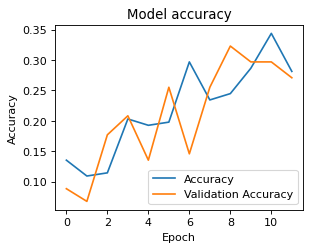

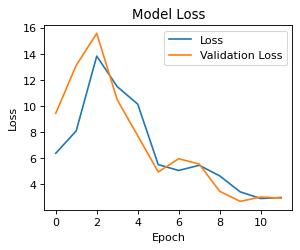

57/57 [==============================] - 20s 354ms/step - loss: 2.9151 - accuracy: 0.2903 - f1_m: 0.2793 - precision_m: 0.3771 - recall_m: 0.2224


,Loss,Accuracy,F1,Precision,Recall
0,2.915114,0.290314,0.279326,0.377116,0.222443


ResNet152_FeatureExtractor.h5 Time 352.9244195000001


In [21]:
from tensorflow.keras.applications import ResNet152
model_pretrained = ResNet152(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

# model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"
output_res_f = get_k_fold_results(model_pretrained,15,10,5,"ResNet152_FeatureExtractor.h5")

In [22]:
output_res_f

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.830764,0.220871,0.196725,0.279690,0.158671
std,1.449520,0.081597,0.060507,0.132018,0.041362
min,2.185834,0.123786,0.124120,0.128044,0.120470
25%,2.915114,0.184846,0.160063,0.213875,0.124452
50%,3.466574,0.185401,0.189439,0.226372,0.155630
75%,4.818569,0.290314,0.230679,0.377116,0.170360
max,5.767728,0.320011,0.279326,0.453046,0.222443


## All weights training

2022-12-15 11:14:00.013293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 11:14:00.013431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_9302/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-12-15 11:14:03.091820: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 4.2112 - accuracy: 0.4115 - f1_m: 0.4002 - precision_m: 0.4208 - recall_m: 0.3854 - val_loss: 16.1837 - val_accuracy: 0.1354 - val_f1_m: 0.1354 - val_precision_m: 0.1354 - val_recall_m: 0.1354
Epoch 2/200
3/3 [==============================] - 9s 3s/step - loss: 1.1110 - accuracy: 0.7240 - f1_m: 0.7313 - precision_m: 0.8218 - recall_m: 0.6615 - val_loss: 308.4280 - val_accuracy: 0.0990 - val_f1_m: 0.0990 - val_precision_m: 0.0990 - val_recall_m: 0.0990
Epoch 3/200
3/3 [==============================] - 9s 3s/step - loss: 0.4322 - accuracy: 0.8594 - f1_m: 0.8406 - precision_m: 0.9212 - recall_m: 0.7760 - val_loss: 44097.6172 - val_accuracy: 0.1458 - val_f1_m: 0.1458 - val_precision_m: 0.1458 - val_recall_m: 0.1458
Epoch 4/200
3/3 [==============================] - 9s 3s/step - loss: 2.5349 - accuracy: 0.7188 - f1_m: 0.7206 - precision_m: 0.7586 - recall_m: 0.6875 - val_loss: 2364052.0000 - val_accuracy: 0.0781 - val_f1_m: 0.0781

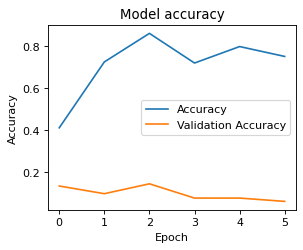

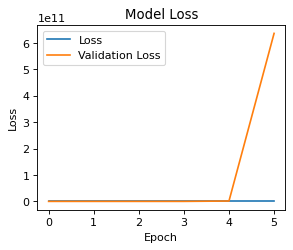

57/57 [==============================] - 19s 336ms/step - loss: 629122203648.0000 - accuracy: 0.0638 - f1_m: 0.0643 - precision_m: 0.0643 - recall_m: 0.0643


,Loss,Accuracy,F1,Precision,Recall
0,6.291222e+11,0.063836,0.064347,0.064347,0.064347


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_9302/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 2.6760 - accuracy: 0.3698 - f1_m: 0.2354 - precision_m: 0.6561 - recall_m: 0.1458 - val_loss: 924266987520.0000 - val_accuracy: 0.1302 - val_f1_m: 0.1302 - val_precision_m: 0.1302 - val_recall_m: 0.1302
Epoch 2/200
3/3 [==============================] - 8s 3s/step - loss: 12.5224 - accuracy: 0.5260 - f1_m: 0.3212 - precision_m: 0.7798 - recall_m: 0.2031 - val_loss: 58197610019684352.0000 - val_accuracy: 0.0573 - val_f1_m: 0.0573 - val_precision_m: 0.0573 - val_recall_m: 0.0573
Epoch 3/200
3/3 [==============================] - 8s 3s/step - loss: 2.6990 - accuracy: 0.4792 - f1_m: 0.2455 - precision_m: 0.7791 - recall_m: 0.1458 - val_loss: 109563859806715904.0000 - val_accuracy: 0.0990 - val_f1_m: 0.0990 - val_precision_m: 0.0990 - val_recall_m: 0.0990
Epoch 4/200
3/3 [==============================] - 8s 3s/step - loss: 1.6069 - accuracy: 0.5052 - f1_m: 0.3325 - precision_m: 0.7564 - recall_m: 0.2135 - val_loss: 1508742811887861

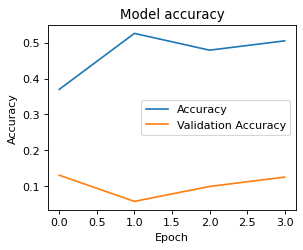

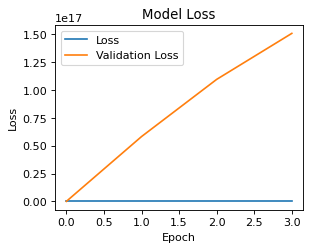

57/57 [==============================] - 19s 326ms/step - loss: 148940738451734528.0000 - accuracy: 0.1210 - f1_m: 0.1221 - precision_m: 0.1221 - recall_m: 0.1221


,Loss,Accuracy,F1,Precision,Recall
0,1.489407e+17,0.12101,0.122114,0.122115,0.122115


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_9302/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 3.9767 - accuracy: 0.3021 - f1_m: 0.0950 - precision_m: 0.5524 - recall_m: 0.0521 - val_loss: 2878866107626550198272.0000 - val_accuracy: 0.1458 - val_f1_m: 0.1458 - val_precision_m: 0.1458 - val_recall_m: 0.1458
Epoch 2/200
3/3 [==============================] - 8s 3s/step - loss: 2.9057 - accuracy: 0.3438 - f1_m: 0.2245 - precision_m: 0.6705 - recall_m: 0.1354 - val_loss: 237118285108870119424.0000 - val_accuracy: 0.0885 - val_f1_m: 0.0885 - val_precision_m: 0.0885 - val_recall_m: 0.0885
Epoch 3/200
3/3 [==============================] - 8s 3s/step - loss: 2.3961 - accuracy: 0.4375 - f1_m: 0.2320 - precision_m: 0.6949 - recall_m: 0.1406 - val_loss: 571771713168080896.0000 - val_accuracy: 0.1146 - val_f1_m: 0.1146 - val_precision_m: 0.1146 - val_recall_m: 0.1146
Epoch 4/200
3/3 [==============================] - 8s 3s/step - loss: 3.1410 - accuracy: 0.5365 - f1_m: 0.3547 - precision_m: 0.7944 - recall_m: 0.2292 - val_loss: 436

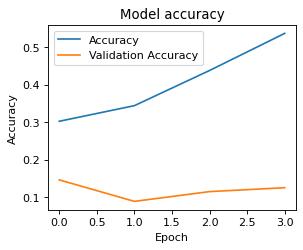

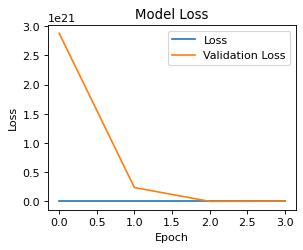

57/57 [==============================] - 19s 326ms/step - loss: 4403060009248751616.0000 - accuracy: 0.1210 - f1_m: 0.1202 - precision_m: 0.1202 - recall_m: 0.1202


,Loss,Accuracy,F1,Precision,Recall
0,4.403060e+18,0.12101,0.120167,0.120167,0.120167


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_9302/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - ETA: 0s - loss: 2.4003 - accuracy: 0.2396 - f1_m: 0.1393 - precision_m: 0.6667 - recall_m: 0.0781

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 2.4003 - accuracy: 0.2396 - f1_m: 0.1393 - precision_m: 0.6667 - recall_m: 0.0781 - val_loss: 5273145616627662848.0000 - val_accuracy: 0.0885 - val_f1_m: 0.0885 - val_precision_m: 0.0885 - val_recall_m: 0.0885
Epoch 2/200
3/3 [==============================] - 9s 3s/step - loss: 1.9500 - accuracy: 0.4167 - f1_m: 0.3406 - precision_m: 0.7333 - recall_m: 0.2240 - val_loss: 1905250496371367084032.0000 - val_accuracy: 0.1510 - val_f1_m: 0.1510 - val_precision_m: 0.1510 - val_recall_m: 0.1510
Epoch 3/200
3/3 [==============================] - 8s 3s/step - loss: 1.5083 - accuracy: 0.5365 - f1_m: 0.3542 - precision_m: 0.7945 - recall_m: 0.2292 - val_loss: 11060479270951841693696.0000 - val_accuracy: 0.1198 - val_f1_m: 0.1198 - val_precision_m: 0.1198 - val_recall_m: 0.1198
Epoch 4/200
3/3 [==============================] - 8s 3s/step - loss: 1.2151 - accuracy: 0.6354 - f1_m: 0.4987 - precision_m: 0.8300 - recall_m: 0.3594 - val_loss: 

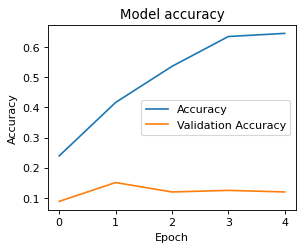

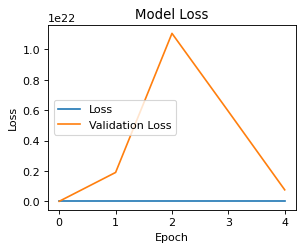

57/57 [==============================] - 19s 326ms/step - loss: 763376532756692467712.0000 - accuracy: 0.1210 - f1_m: 0.1208 - precision_m: 0.1208 - recall_m: 0.1208


,Loss,Accuracy,F1,Precision,Recall
0,7.633765e+20,0.12101,0.120816,0.120816,0.120816


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_9302/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 10s 3s/step - loss: 2.1064 - accuracy: 0.3698 - f1_m: 0.1539 - precision_m: 0.5079 - recall_m: 0.0938 - val_loss: 5111018229065580544.0000 - val_accuracy: 0.1510 - val_f1_m: 0.1510 - val_precision_m: 0.1510 - val_recall_m: 0.1510
Epoch 2/200
3/3 [==============================] - 8s 3s/step - loss: 1.0571 - accuracy: 0.6719 - f1_m: 0.5660 - precision_m: 0.9056 - recall_m: 0.4219 - val_loss: 67784204657623040.0000 - val_accuracy: 0.1458 - val_f1_m: 0.1458 - val_precision_m: 0.1458 - val_recall_m: 0.1458
Epoch 3/200
3/3 [==============================] - 8s 3s/step - loss: 0.8315 - accuracy: 0.7448 - f1_m: 0.6828 - precision_m: 0.8463 - recall_m: 0.5729 - val_loss: 670772020379648.0000 - val_accuracy: 0.0781 - val_f1_m: 0.0781 - val_precision_m: 0.0781 - val_recall_m: 0.0781
Epoch 4/200
3/3 [==============================] - 9s 3s/step - loss: 1.3971 - accuracy: 0.6927 - f1_m: 0.6530 - precision_m: 0.8059 - recall_m: 0.5521 - val_loss: 1918355061604

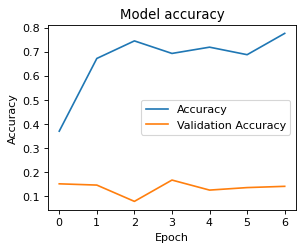

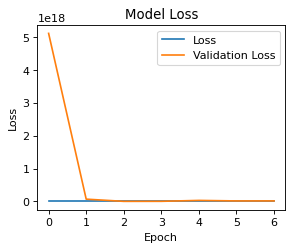

57/57 [==============================] - 19s 321ms/step - loss: 14534797468631040.0000 - accuracy: 0.1210 - f1_m: 0.1215 - precision_m: 0.1215 - recall_m: 0.1215


,Loss,Accuracy,F1,Precision,Recall
0,1.453480e+16,0.12101,0.121465,0.121465,0.121465


ResNet152_All.h5 Time 359.178111334


In [10]:
from tensorflow.keras.applications import ResNet152
model_h2t = ResNet152(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )
for layer in model_h2t.layers:
    layer.trainable = True

output_res_all = get_k_fold_results(model_h2t,200,10,5,"ResNet152_All.h5")

In [11]:
output_res_all

,Loss,Accuracy,F1,Precision,Recall
count,5.000000e+00,5.000000,5.000000,5.000000,5.000000
mean,1.535886e+20,0.109575,0.109782,0.109782,0.109782
std,3.408870e+20,0.025569,0.025409,0.025409,0.025409
min,6.291222e+11,0.063836,0.064347,0.064347,0.064347
25%,1.453480e+16,0.121010,0.120167,0.120167,0.120167
50%,1.489407e+17,0.121010,0.120816,0.120816,0.120816
75%,4.403060e+18,0.121010,0.121465,0.121465,0.121465
max,7.633765e+20,0.121010,0.122114,0.122115,0.122115


## Last two layers fine tune

0 input_10 -- False
1 conv1_pad -- False
2 conv1_conv -- False
3 conv1_bn -- False
4 conv1_relu -- False
5 pool1_pad -- False
6 pool1_pool -- False
7 conv2_block1_1_conv -- False
8 conv2_block1_1_bn -- False
9 conv2_block1_1_relu -- False
10 conv2_block1_2_conv -- False
11 conv2_block1_2_bn -- False
12 conv2_block1_2_relu -- False
13 conv2_block1_0_conv -- False
14 conv2_block1_3_conv -- False
15 conv2_block1_0_bn -- False
16 conv2_block1_3_bn -- False
17 conv2_block1_add -- False
18 conv2_block1_out -- False
19 conv2_block2_1_conv -- False
20 conv2_block2_1_bn -- False
21 conv2_block2_1_relu -- False
22 conv2_block2_2_conv -- False
23 conv2_block2_2_bn -- False
24 conv2_block2_2_relu -- False
25 conv2_block2_3_conv -- False
26 conv2_block2_3_bn -- False
27 conv2_block2_add -- False
28 conv2_block2_out -- False
29 conv2_block3_1_conv -- False
30 conv2_block3_1_bn -- False
31 conv2_block3_1_relu -- False
32 conv2_block3_2_conv -- False
33 conv2_block3_2_bn -- False
34 conv2_block3_2_rel

Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 8s 2s/step - loss: 7.2535 - accuracy: 0.1042 - f1_m: 0.0435 - precision_m: 0.0461 - recall_m: 0.0417 - val_loss: 9.6351 - val_accuracy: 0.2083 - val_f1_m: 0.1890 - val_precision_m: 0.3920 - val_recall_m: 0.1250
Epoch 2/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 9.7364 - accuracy: 0.1771 - f1_m: 0.1535 - precision_m: 0.2157 - recall_m: 0.1302 - val_loss: 7.4184 - val_accuracy: 0.1198 - val_f1_m: 0.1198 - val_precision_m: 0.1198 - val_recall_m: 0.1198
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 8.2706 - accuracy: 0.0990 - f1_m: 0.0990 - precision_m: 0.0990 - recall_m: 0.0990 - val_loss: 9.7930 - val_accuracy: 0.1510 - val_f1_m: 0.1531 - val_precision_m: 0.1552 - val_recall_m: 0.1510
Epoch 4/50
3/3 [==============================] - 7s 3s/step - loss: 8.3481 - accuracy: 0.0990 - f1_m: 0.0733 - precision_m: 0.0896 - recall_m: 0.0677 - val_loss: 4.7836 - val_accuracy: 0.1302 - val_f1_m: 0.1338 - val_precision_m: 0.1515 - val_recall_m: 0.1198
Epoch 4: early stopping


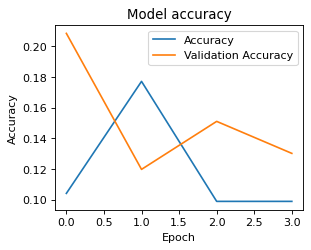

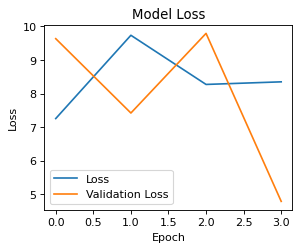

57/57 [==============================] - 20s 338ms/step - loss: 4.7964 - accuracy: 0.1241 - f1_m: 0.1298 - precision_m: 0.1509 - recall_m: 0.1140


,Loss,Accuracy,F1,Precision,Recall
0,4.796408,0.124063,0.129775,0.150946,0.113963


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 8.5637 - accuracy: 0.1146 - f1_m: 0.0349 - precision_m: 0.0563 - recall_m: 0.0312 - val_loss: 8.5957 - val_accuracy: 0.1042 - val_f1_m: 0.1042 - val_precision_m: 0.1042 - val_recall_m: 0.1042
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 7.3541 - accuracy: 0.1250 - f1_m: 0.1206 - precision_m: 0.1215 - recall_m: 0.1198 - val_loss: 8.9443 - val_accuracy: 0.1562 - val_f1_m: 0.1562 - val_precision_m: 0.1562 - val_recall_m: 0.1562
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 7.9291 - accuracy: 0.2240 - f1_m: 0.2053 - precision_m: 0.2610 - recall_m: 0.1719 - val_loss: 7.4461 - val_accuracy: 0.1354 - val_f1_m: 0.1354 - val_precision_m: 0.1354 - val_recall_m: 0.1354
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 5.6137 - accuracy: 0.1562 - f1_m: 0.1563 - precision_m: 0.1719 - recall_m: 0.1458 - val_loss: 5.4708 - val_accuracy: 0.1458 - val_f1_m: 0.1393 - val_precision_

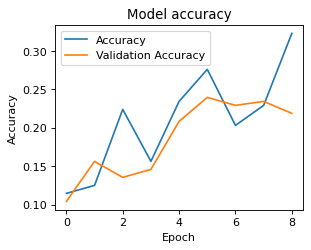

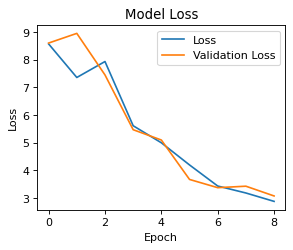

57/57 [==============================] - 20s 353ms/step - loss: 2.9033 - accuracy: 0.2565 - f1_m: 0.2548 - precision_m: 0.2765 - recall_m: 0.2364


,Loss,Accuracy,F1,Precision,Recall
0,2.90335,0.256453,0.254767,0.276525,0.236424


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 7s 3s/step - loss: 7.0581 - accuracy: 0.1667 - f1_m: 0.0880 - precision_m: 0.3842 - recall_m: 0.0677 - val_loss: 11.1408 - val_accuracy: 0.1042 - val_f1_m: 0.1042 - val_precision_m: 0.1042 - val_recall_m: 0.1042
Epoch 2/50
3/3 [==============================] - 7s 3s/step - loss: 8.7985 - accuracy: 0.1667 - f1_m: 0.1618 - precision_m: 0.1621 - recall_m: 0.1615 - val_loss: 7.2743 - val_accuracy: 0.1406 - val_f1_m: 0.0942 - val_precision_m: 0.1188 - val_recall_m: 0.0781
Epoch 3/50
3/3 [==============================] - 8s 3s/step - loss: 6.2433 - accuracy: 0.1406 - f1_m: 0.1127 - precision_m: 0.1468 - recall_m: 0.0938 - val_loss: 5.0618 - val_accuracy: 0.1354 - val_f1_m: 0.0994 - val_precision_m: 0.1234 - val_recall_m: 0.0833
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 5.7338 - accuracy: 0.1302 - f1_m: 0.1364 - precision_m: 0.1552 - recall_m: 0.1250 - val_loss: 5.3222 - val_accuracy: 0.1562 - val_f1_m: 0.1555 - val_precision

3/3 [==============================] - 6s 2s/step - loss: 2.2472 - accuracy: 0.3385 - f1_m: 0.3189 - precision_m: 0.6147 - recall_m: 0.2188 - val_loss: 2.9092 - val_accuracy: 0.3177 - val_f1_m: 0.2882 - val_precision_m: 0.5364 - val_recall_m: 0.1979
Epoch 12/50
3/3 [==============================] - 5s 2s/step - loss: 2.1404 - accuracy: 0.4062 - f1_m: 0.2902 - precision_m: 0.6057 - recall_m: 0.1979 - val_loss: 2.0647 - val_accuracy: 0.3021 - val_f1_m: 0.3363 - val_precision_m: 0.6879 - val_recall_m: 0.2240
Epoch 13/50
3/3 [==============================] - 5s 2s/step - loss: 2.1906 - accuracy: 0.3333 - f1_m: 0.3148 - precision_m: 0.5372 - recall_m: 0.2292 - val_loss: 1.9083 - val_accuracy: 0.3542 - val_f1_m: 0.2687 - val_precision_m: 0.7196 - val_recall_m: 0.1667
Epoch 14/50
3/3 [==============================] - 5s 2s/step - loss: 1.6939 - accuracy: 0.4792 - f1_m: 0.3819 - precision_m: 0.8108 - recall_m: 0.2500 - val_loss: 1.8574 - val_accuracy: 0.3698 - val_f1_m: 0.3020 - val_precisi

Epoch 21: early stopping


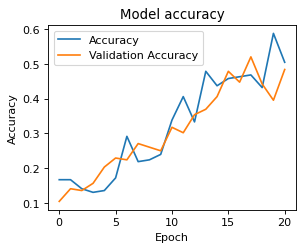

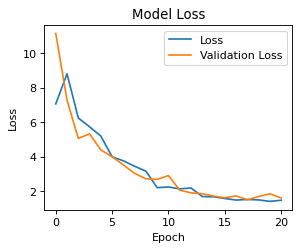

57/57 [==============================] - 21s 361ms/step - loss: 1.5558 - accuracy: 0.4876 - f1_m: 0.3517 - precision_m: 0.8083 - recall_m: 0.2258


,Loss,Accuracy,F1,Precision,Recall
0,1.555796,0.487649,0.351653,0.808292,0.225805


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/3 [=========>....................] - ETA: 3s - loss: 2.8300 - accuracy: 0.0625 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 6.1447 - accuracy: 0.1146 - f1_m: 0.0469 - precision_m: 0.0469 - recall_m: 0.0469 - val_loss: 6.1997 - val_accuracy: 0.1250 - val_f1_m: 0.1187 - val_precision_m: 0.1299 - val_recall_m: 0.1094
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 6.7586 - accuracy: 0.2031 - f1_m: 0.2026 - precision_m: 0.2399 - recall_m: 0.1771 - val_loss: 4.9954 - val_accuracy: 0.1875 - val_f1_m: 0.1867 - val_precision_m: 0.1978 - val_recall_m: 0.1771
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 5.5415 - accuracy: 0.1562 - f1_m: 0.1108 - precision_m: 0.2353 - recall_m: 0.0938 - val_loss: 5.5713 - val_accuracy: 0.1979 - val_f1_m: 0.1857 - val_precision_m: 0.1953 - val_recall_m: 0.1771
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 4.4113 - accuracy: 0.1823 - f1_m: 0.1762 - precision_m: 0.1873 - recall_m: 0.1667 - val_loss: 4.2105 - val_accuracy: 0.1615 - val_f1_m: 0.1444 - val_precision_

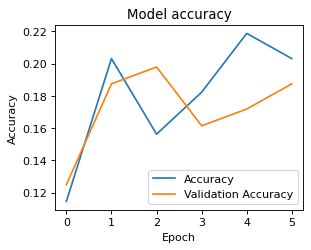

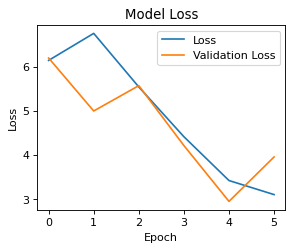

57/57 [==============================] - 20s 344ms/step - loss: 3.7450 - accuracy: 0.2140 - f1_m: 0.1988 - precision_m: 0.3314 - recall_m: 0.1428


,Loss,Accuracy,F1,Precision,Recall
0,3.745016,0.213988,0.198796,0.331387,0.142847


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 7.2811 - accuracy: 0.1032 - f1_m: 0.0328 - precision_m: 0.0345 - recall_m: 0.0312 - val_loss: 11.4225 - val_accuracy: 0.0990 - val_f1_m: 0.0990 - val_precision_m: 0.0990 - val_recall_m: 0.0990
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 7.7212 - accuracy: 0.1823 - f1_m: 0.1490 - precision_m: 0.4435 - recall_m: 0.1302 - val_loss: 7.3756 - val_accuracy: 0.2083 - val_f1_m: 0.2024 - val_precision_m: 0.2134 - val_recall_m: 0.1927
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 8.4634 - accuracy: 0.2344 - f1_m: 0.2330 - precision_m: 0.2370 - recall_m: 0.2292 - val_loss: 5.3619 - val_accuracy: 0.1927 - val_f1_m: 0.1778 - val_precision_m: 0.1986 - val_recall_m: 0.1615
Epoch 4/50
3/3 [==============================] - 5s 2s/step - loss: 5.9847 - accuracy: 0.2031 - f1_m: 0.2109 - precision_m: 0.2267 - recall_m: 0.1979 - val_loss: 6.9457 - val_accuracy: 0.1458 - val_f1_m: 0.1369 - val_precision

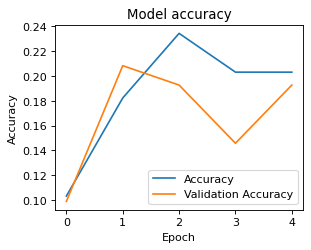

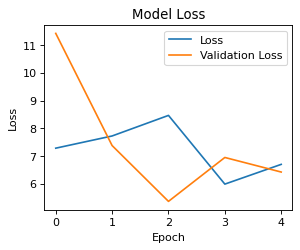

57/57 [==============================] - 20s 347ms/step - loss: 6.4733 - accuracy: 0.2143 - f1_m: 0.2223 - precision_m: 0.2650 - recall_m: 0.1920


,Loss,Accuracy,F1,Precision,Recall
0,6.473291,0.214266,0.222253,0.265022,0.192045


ResNet152_FineTune.h5 Time 372.0679823749997


In [25]:
from tensorflow.keras.applications import ResNet152
model_last2 = ResNet152(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for layer in model_last2.layers[:-2]:
    layer.trainable=False

for i, layer in enumerate(model_last2.layers):
    print(i,layer.name, "--",layer.trainable)

output_res_last2 = get_k_fold_results(model_last2,50,10,5,"ResNet152_FineTune.h5")

In [26]:
output_res_last2

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.894772,0.259284,0.231449,0.366434,0.182217
std,1.866673,0.136493,0.081365,0.255573,0.052781
min,1.555796,0.124063,0.129775,0.150946,0.113963
25%,2.903350,0.213988,0.198796,0.265022,0.142847
50%,3.745016,0.214266,0.222253,0.276525,0.192045
75%,4.796408,0.256453,0.254767,0.331387,0.225805
max,6.473291,0.487649,0.351653,0.808292,0.236424


# Xception

## Feature Extractor

====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 6s 1s/step - loss: 2.2686 - accuracy: 0.2500 - f1_m: 0.1912 - precision_m: 0.3620 - recall_m: 0.1302 - val_loss: 1.5860 - val_accuracy: 0.5260 - val_f1_m: 0.4310 - val_precision_m: 0.6962 - val_recall_m: 0.3125
Epoch 2/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.3831 - accuracy: 0.5573 - f1_m: 0.5180 - precision_m: 0.7239 - recall_m: 0.4062 - val_loss: 1.3039 - val_accuracy: 0.5938 - val_f1_m: 0.5461 - val_precision_m: 0.7127 - val_recall_m: 0.4427
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 1.0272 - accuracy: 0.7083 - f1_m: 0.6574 - precision_m: 0.8023 - recall_m: 0.5573 - val_loss: 1.0612 - val_accuracy: 0.6562 - val_f1_m: 0.6406 - val_precision_m: 0.7539 - val_recall_m: 0.5573
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.7146 - accuracy: 0.7656 - f1_m: 0.7453 - precision_m: 0.8370 - recall_m: 0.6719 - val_loss: 0.9183 - val_accuracy: 0.6979 - val_f1_m: 0.6813 - val_precision_m: 0.7742 - val_recall_m: 0.6094
Epoch 5/15
3/3 [==============================] - 3s 1s/step - loss: 0.6442 - accuracy: 0.8177 - f1_m: 0.7723 - precision_m: 0.8497 - recall_m: 0.7083 - val_loss: 0.6463 - val_accuracy: 0.8177 - val_f1_m: 0.7902 - val_precision_

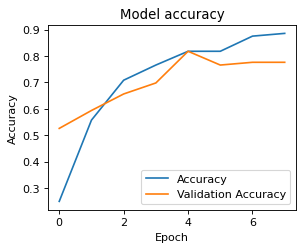

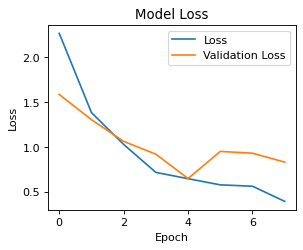

57/57 [==============================] - 15s 258ms/step - loss: 0.8765 - accuracy: 0.7824 - f1_m: 0.7694 - precision_m: 0.8340 - recall_m: 0.7150


,Loss,Accuracy,F1,Precision,Recall
0,0.876479,0.782404,0.769434,0.83397,0.714956


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.7879 - accuracy: 0.4062 - f1_m: 0.1907 - precision_m: 0.5344 - recall_m: 0.1198 - val_loss: 1.1705 - val_accuracy: 0.6667 - val_f1_m: 0.4939 - val_precision_m: 0.8506 - val_recall_m: 0.3490
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 0.9613 - accuracy: 0.7135 - f1_m: 0.5961 - precision_m: 0.9119 - recall_m: 0.4479 - val_loss: 1.1076 - val_accuracy: 0.6302 - val_f1_m: 0.6204 - val_precision_m: 0.7825 - val_recall_m: 0.5156
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.6256 - accuracy: 0.8385 - f1_m: 0.7757 - precision_m: 0.9284 - recall_m: 0.6667 - val_loss: 0.9733 - val_accuracy: 0.7135 - val_f1_m: 0.6866 - val_precision_m: 0.8052 - val_recall_m: 0.5990
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.5510 - accuracy: 0.8281 - f1_m: 0.7909 - precision_m: 0.8962 - recall_m: 0.7083 - val_loss: 0.8141 - val_accuracy: 0.7760 - val_f1_m: 0.7611 - val_precision_

3/3 [==============================] - 3s 1s/step - loss: 0.2362 - accuracy: 0.9219 - f1_m: 0.9251 - precision_m: 0.9505 - recall_m: 0.9010 - val_loss: 0.8536 - val_accuracy: 0.8125 - val_f1_m: 0.8124 - val_precision_m: 0.8530 - val_recall_m: 0.7760
Epoch 11: early stopping


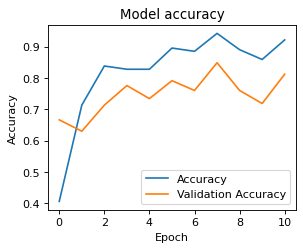

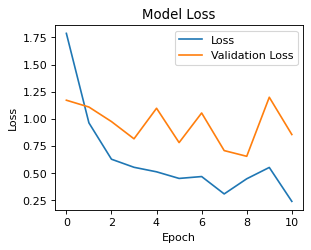

57/57 [==============================] - 15s 255ms/step - loss: 0.8453 - accuracy: 0.8066 - f1_m: 0.7945 - precision_m: 0.8328 - recall_m: 0.7602


,Loss,Accuracy,F1,Precision,Recall
0,0.845287,0.80655,0.794514,0.832792,0.760186


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 2.1053 - accuracy: 0.2708 - f1_m: 0.1933 - precision_m: 0.3379 - recall_m: 0.1354 - val_loss: 1.4660 - val_accuracy: 0.5677 - val_f1_m: 0.4827 - val_precision_m: 0.7406 - val_recall_m: 0.3594
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.2188 - accuracy: 0.5990 - f1_m: 0.4807 - precision_m: 0.6930 - recall_m: 0.3698 - val_loss: 1.0298 - val_accuracy: 0.6875 - val_f1_m: 0.6166 - val_precision_m: 0.8215 - val_recall_m: 0.4948
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.7975 - accuracy: 0.7812 - f1_m: 0.7139 - precision_m: 0.8572 - recall_m: 0.6146 - val_loss: 0.9529 - val_accuracy: 0.6875 - val_f1_m: 0.6319 - val_precision_m: 0.8079 - val_recall_m: 0.5208
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.7677 - accuracy: 0.8073 - f1_m: 0.7539 - precision_m: 0.8870 - recall_m: 0.6562 - val_loss: 0.9264 - val_accuracy: 0.7396 - val_f1_m: 0.7135 - val_precision_

3/3 [==============================] - 3s 1s/step - loss: 0.2587 - accuracy: 0.9219 - f1_m: 0.9167 - precision_m: 0.9391 - recall_m: 0.8958 - val_loss: 0.6789 - val_accuracy: 0.8229 - val_f1_m: 0.8184 - val_precision_m: 0.8667 - val_recall_m: 0.7760
Epoch 12/15
3/3 [==============================] - 3s 1s/step - loss: 0.5145 - accuracy: 0.8802 - f1_m: 0.8749 - precision_m: 0.9148 - recall_m: 0.8385 - val_loss: 0.4883 - val_accuracy: 0.8438 - val_f1_m: 0.8320 - val_precision_m: 0.8832 - val_recall_m: 0.7865
Epoch 13/15
3/3 [==============================] - 3s 1s/step - loss: 0.3488 - accuracy: 0.8854 - f1_m: 0.8775 - precision_m: 0.9205 - recall_m: 0.8385 - val_loss: 0.5502 - val_accuracy: 0.8490 - val_f1_m: 0.8457 - val_precision_m: 0.8950 - val_recall_m: 0.8021
Epoch 14/15
3/3 [==============================] - 3s 1s/step - loss: 0.2611 - accuracy: 0.9167 - f1_m: 0.9110 - precision_m: 0.9441 - recall_m: 0.8802 - val_loss: 0.6873 - val_accuracy: 0.8281 - val_f1_m: 0.8023 - val_precisi

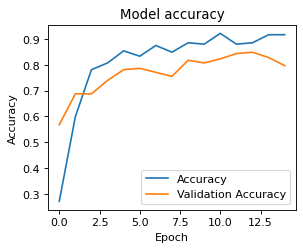

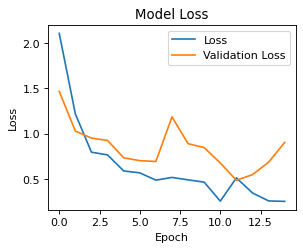

57/57 [==============================] - 16s 268ms/step - loss: 0.7872 - accuracy: 0.8082 - f1_m: 0.8009 - precision_m: 0.8433 - recall_m: 0.7631


,Loss,Accuracy,F1,Precision,Recall
0,0.787179,0.808215,0.800894,0.843285,0.763129


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 2.3373 - accuracy: 0.2656 - f1_m: 0.1731 - precision_m: 0.3598 - recall_m: 0.1146 - val_loss: 1.4745 - val_accuracy: 0.5208 - val_f1_m: 0.4486 - val_precision_m: 0.7398 - val_recall_m: 0.3229
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.0644 - accuracy: 0.6719 - f1_m: 0.6061 - precision_m: 0.8387 - recall_m: 0.4792 - val_loss: 1.1521 - val_accuracy: 0.6302 - val_f1_m: 0.5885 - val_precision_m: 0.7684 - val_recall_m: 0.4792
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.8053 - accuracy: 0.7604 - f1_m: 0.6950 - precision_m: 0.8617 - recall_m: 0.5833 - val_loss: 0.9710 - val_accuracy: 0.7396 - val_f1_m: 0.7223 - val_precision_m: 0.8560 - val_recall_m: 0.6250
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.7200 - accuracy: 0.8021 - f1_m: 0.7228 - precision_m: 0.8497 - recall_m: 0.6302 - val_loss: 0.9575 - val_accuracy: 0.6823 - val_f1_m: 0.6606 - val_precision_

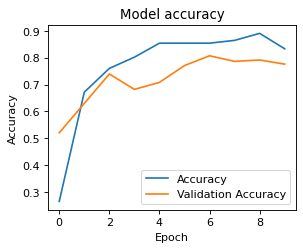

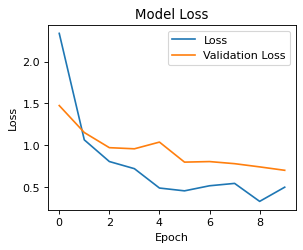

57/57 [==============================] - 16s 279ms/step - loss: 0.6793 - accuracy: 0.8143 - f1_m: 0.7985 - precision_m: 0.8590 - recall_m: 0.7469


,Loss,Accuracy,F1,Precision,Recall
0,0.679335,0.814321,0.798544,0.859047,0.746855


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/15


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.9989 - accuracy: 0.3177 - f1_m: 0.2056 - precision_m: 0.4025 - recall_m: 0.1406 - val_loss: 1.4883 - val_accuracy: 0.6042 - val_f1_m: 0.5294 - val_precision_m: 0.8085 - val_recall_m: 0.3958
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.2717 - accuracy: 0.6510 - f1_m: 0.5564 - precision_m: 0.7872 - recall_m: 0.4323 - val_loss: 1.1535 - val_accuracy: 0.6198 - val_f1_m: 0.5897 - val_precision_m: 0.7682 - val_recall_m: 0.4792
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.9510 - accuracy: 0.7188 - f1_m: 0.6646 - precision_m: 0.8017 - recall_m: 0.5677 - val_loss: 0.9578 - val_accuracy: 0.7135 - val_f1_m: 0.6805 - val_precision_m: 0.8250 - val_recall_m: 0.5833
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 0.7415 - accuracy: 0.8177 - f1_m: 0.7532 - precision_m: 0.8937 - recall_m: 0.6510 - val_loss: 1.0521 - val_accuracy: 0.7083 - val_f1_m: 0.7079 - val_precision_

2022-12-14 17:56:01.029771: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x169fd7c20>
Traceback (most recent call last):

  File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "/Users/amankesarwani

3/3 [==============================] - 3s 1s/step - loss: 0.7399 - accuracy: 0.7917 - f1_m: 0.7815 - precision_m: 0.8507 - recall_m: 0.7240 - val_loss: 0.7849 - val_accuracy: 0.7552 - val_f1_m: 0.7525 - val_precision_m: 0.8315 - val_recall_m: 0.6875
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 0.4787 - accuracy: 0.8438 - f1_m: 0.8308 - precision_m: 0.8874 - recall_m: 0.7812 - val_loss: 0.8501 - val_accuracy: 0.7552 - val_f1_m: 0.7509 - val_precision_m: 0.8200 - val_recall_m: 0.6927
Epoch 7/15
3/3 [==============================] - 3s 1s/step - loss: 0.4996 - accuracy: 0.8490 - f1_m: 0.8475 - precision_m: 0.9052 - recall_m: 0.7969 - val_loss: 0.9203 - val_accuracy: 0.6562 - val_f1_m: 0.6831 - val_precision_m: 0.7696 - val_recall_m: 0.6146
Epoch 8/15
3/3 [==============================] - 3s 1s/step - loss: 0.4893 - accuracy: 0.8333 - f1_m: 0.8266 - precision_m: 0.9132 - recall_m: 0.7552 - val_loss: 0.8077 - val_accuracy: 0.7708 - val_f1_m: 0.7392 - val_precision_

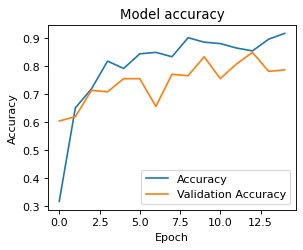

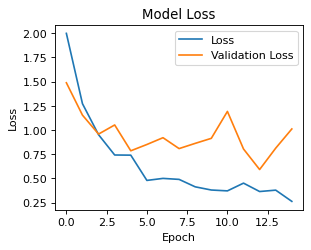

57/57 [==============================] - 15s 259ms/step - loss: 0.8501 - accuracy: 0.8160 - f1_m: 0.8059 - precision_m: 0.8504 - recall_m: 0.7666


,Loss,Accuracy,F1,Precision,Recall
0,0.850117,0.815987,0.805945,0.850379,0.766563


Xception_FeatureExtractor.h5 Time 277.13534083299965


In [15]:
from tensorflow.keras.applications import Xception
model_pretrained = Xception(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for  layer in model_pretrained.layers:
    layer.trainable = False

# model_input,epochs=10,OUTPUT_CLASS=2,k=5,modelname="FeatureExtractor.h5"
output_xcp_f = get_k_fold_results(model_pretrained,15,10,5,"Xception_FeatureExtractor.h5")

In [16]:
output_xcp_f

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.807679,0.805495,0.793866,0.843895,0.750338
std,0.078806,0.013507,0.014270,0.011111,0.021142
min,0.679335,0.782404,0.769434,0.832792,0.714956
25%,0.787179,0.806550,0.794514,0.833970,0.746855
50%,0.845287,0.808215,0.798544,0.843285,0.760186
75%,0.850117,0.814321,0.800894,0.850379,0.763129
max,0.876479,0.815987,0.805945,0.859047,0.766563


## All weights training

====== K Fold Validation step => 0 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/3 [=========>....................] - ETA: 5s - loss: 2.3770 - accuracy: 0.1094 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 2.3319 - accuracy: 0.2135 - f1_m: 0.0093 - precision_m: 0.0417 - recall_m: 0.0052 - val_loss: 2.1220 - val_accuracy: 0.4635 - val_f1_m: 0.3402 - val_precision_m: 0.6646 - val_recall_m: 0.2292
Epoch 2/200
3/3 [==============================] - 5s 2s/step - loss: 2.3021 - accuracy: 0.1198 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.7990 - val_accuracy: 0.3906 - val_f1_m: 0.2540 - val_precision_m: 0.8278 - val_recall_m: 0.1510
Epoch 3/200
3/3 [==============================] - 5s 2s/step - loss: 2.3022 - accuracy: 0.1406 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.8795 - val_accuracy: 0.3802 - val_f1_m: 0.1691 - val_precision_m: 0.9333 - val_recall_m: 0.0938
Epoch 4/200
3/3 [==============================] - 5s 2s/step - loss: 2.3021 - accuracy: 0.0990 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9121 - val_accuracy: 0.4

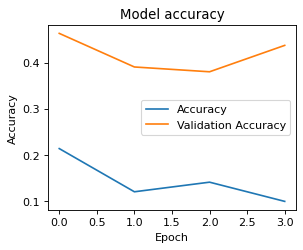

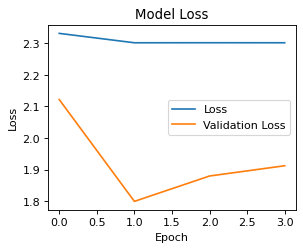

57/57 [==============================] - 14s 243ms/step - loss: 1.9066 - accuracy: 0.3969 - f1_m: 0.1412 - precision_m: 0.9115 - recall_m: 0.0777


,Loss,Accuracy,F1,Precision,Recall
0,1.906575,0.396892,0.141177,0.911514,0.077678


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 2.2946 - accuracy: 0.1458 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.1208 - val_accuracy: 0.1875 - val_f1_m: 0.0782 - val_precision_m: 0.6667 - val_recall_m: 0.0417
Epoch 2/200
3/3 [==============================] - 4s 2s/step - loss: 2.1715 - accuracy: 0.2344 - f1_m: 0.0202 - precision_m: 0.3333 - recall_m: 0.0104 - val_loss: 1.9014 - val_accuracy: 0.2917 - val_f1_m: 0.0833 - val_precision_m: 0.4333 - val_recall_m: 0.0469
Epoch 3/200
3/3 [==============================] - 5s 2s/step - loss: 1.7020 - accuracy: 0.4792 - f1_m: 0.3401 - precision_m: 0.8357 - recall_m: 0.2240 - val_loss: 3.1713 - val_accuracy: 0.2812 - val_f1_m: 0.3144 - val_precision_m: 0.4836 - val_recall_m: 0.2344
Epoch 4/200
3/3 [==============================] - 5s 2s/step - loss: 1.4901 - accuracy: 0.5417 - f1_m: 0.5238 - precision_m: 0.8439 - recall_m: 0.3802 - val_loss: 5.1678 - val_accuracy: 0.3385 - val_f1_m: 0.3963 -

3/3 [==============================] - 5s 2s/step - loss: 0.6100 - accuracy: 0.8177 - f1_m: 0.8030 - precision_m: 0.9193 - recall_m: 0.7135 - val_loss: 3.3089 - val_accuracy: 0.4792 - val_f1_m: 0.5096 - val_precision_m: 0.5825 - val_recall_m: 0.4531
Epoch 12/200
3/3 [==============================] - 5s 2s/step - loss: 0.4880 - accuracy: 0.8438 - f1_m: 0.8514 - precision_m: 0.9434 - recall_m: 0.7760 - val_loss: 3.3736 - val_accuracy: 0.5521 - val_f1_m: 0.5675 - val_precision_m: 0.6024 - val_recall_m: 0.5365
Epoch 13/200
3/3 [==============================] - 5s 2s/step - loss: 0.4078 - accuracy: 0.9115 - f1_m: 0.8778 - precision_m: 0.9621 - recall_m: 0.8073 - val_loss: 3.0591 - val_accuracy: 0.5417 - val_f1_m: 0.5482 - val_precision_m: 0.5788 - val_recall_m: 0.5208
Epoch 14/200
3/3 [==============================] - 5s 2s/step - loss: 0.3477 - accuracy: 0.9271 - f1_m: 0.8916 - precision_m: 0.9483 - recall_m: 0.8438 - val_loss: 3.7147 - val_accuracy: 0.5365 - val_f1_m: 0.5478 - val_prec

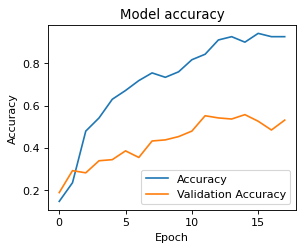

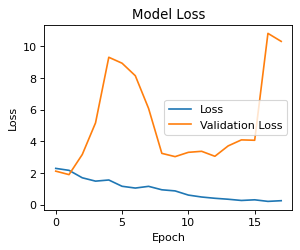

57/57 [==============================] - 14s 241ms/step - loss: 8.3921 - accuracy: 0.5648 - f1_m: 0.5376 - precision_m: 0.5757 - recall_m: 0.5047


,Loss,Accuracy,F1,Precision,Recall
0,8.392098,0.564807,0.537574,0.575691,0.504747


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 1.4954 - accuracy: 0.5938 - f1_m: 0.3610 - precision_m: 0.6667 - recall_m: 0.2865 - val_loss: 5.1900 - val_accuracy: 0.5833 - val_f1_m: 0.5507 - val_precision_m: 0.6153 - val_recall_m: 0.5000
Epoch 2/200
3/3 [==============================] - 4s 2s/step - loss: 0.3219 - accuracy: 0.9323 - f1_m: 0.9195 - precision_m: 0.9510 - recall_m: 0.8906 - val_loss: 4.3063 - val_accuracy: 0.4844 - val_f1_m: 0.4579 - val_precision_m: 0.5163 - val_recall_m: 0.4115
Epoch 3/200
3/3 [==============================] - 4s 2s/step - loss: 0.5166 - accuracy: 0.9115 - f1_m: 0.9052 - precision_m: 0.9150 - recall_m: 0.8958 - val_loss: 4.7887 - val_accuracy: 0.4479 - val_f1_m: 0.4259 - val_precision_m: 0.4610 - val_recall_m: 0.3958
Epoch 4/200
3/3 [==============================] - 4s 2s/step - loss: 0.5419 - accuracy: 0.8802 - f1_m: 0.8764 - precision_m: 0.9000 - recall_m: 0.8542 - val_loss: 3.8958 - val_accuracy: 0.5208 - val_f1_m: 0.4924 - val_precisi

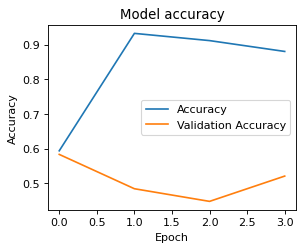

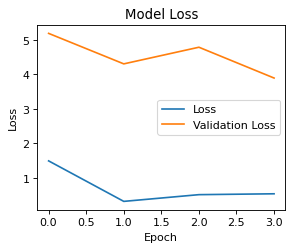

57/57 [==============================] - 14s 241ms/step - loss: 4.4809 - accuracy: 0.5057 - f1_m: 0.4895 - precision_m: 0.5327 - recall_m: 0.4535


,Loss,Accuracy,F1,Precision,Recall
0,4.480899,0.50569,0.489507,0.532697,0.453515


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 6s 2s/step - loss: 1.1743 - accuracy: 0.7083 - f1_m: 0.5565 - precision_m: 0.6667 - recall_m: 0.4792 - val_loss: 2.6709 - val_accuracy: 0.5833 - val_f1_m: 0.6012 - val_precision_m: 0.6675 - val_recall_m: 0.5469
Epoch 2/200
3/3 [==============================] - 4s 2s/step - loss: 0.3768 - accuracy: 0.9219 - f1_m: 0.9308 - precision_m: 0.9510 - recall_m: 0.9115 - val_loss: 2.7999 - val_accuracy: 0.7240 - val_f1_m: 0.6728 - val_precision_m: 0.7366 - val_recall_m: 0.6198
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 0.5241 - accuracy: 0.9115 - f1_m: 0.8948 - precision_m: 0.9280 - recall_m: 0.8646 - val_loss: 1.9702 - val_accuracy: 0.8177 - val_f1_m: 0.7996 - val_precision_m: 0.8868 - val_recall_m: 0.7292
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 0.2441 - accuracy: 0.9427 - f1_m: 0.9243 - precision_m: 0.9606 - recall_m: 0.8906 - val_loss: 2.0061 - val_accuracy: 0.8125 - val_f1_m: 0.8122 - val_precisi

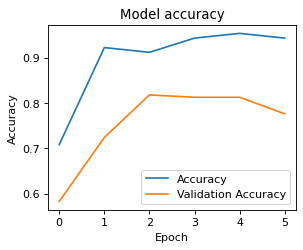

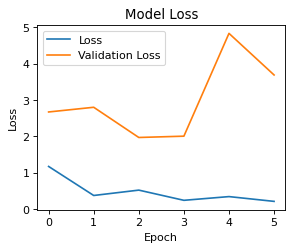

57/57 [==============================] - 14s 242ms/step - loss: 3.6016 - accuracy: 0.8288 - f1_m: 0.8152 - precision_m: 0.8557 - recall_m: 0.7788


,Loss,Accuracy,F1,Precision,Recall
0,3.601573,0.828754,0.81523,0.855706,0.778826


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_7187/1867010446.py:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 5s 2s/step - loss: 1.2578 - accuracy: 0.6510 - f1_m: 0.4824 - precision_m: 0.6556 - recall_m: 0.4167 - val_loss: 2.4841 - val_accuracy: 0.7292 - val_f1_m: 0.7200 - val_precision_m: 0.7440 - val_recall_m: 0.6979
Epoch 2/200
3/3 [==============================] - 5s 2s/step - loss: 0.4456 - accuracy: 0.9010 - f1_m: 0.9101 - precision_m: 0.9247 - recall_m: 0.8958 - val_loss: 2.7635 - val_accuracy: 0.8021 - val_f1_m: 0.8060 - val_precision_m: 0.8100 - val_recall_m: 0.8021
Epoch 3/200
3/3 [==============================] - 4s 2s/step - loss: 0.2139 - accuracy: 0.9531 - f1_m: 0.9501 - precision_m: 0.9577 - recall_m: 0.9427 - val_loss: 5.1631 - val_accuracy: 0.8646 - val_f1_m: 0.8668 - val_precision_m: 0.8690 - val_recall_m: 0.8646
Epoch 4/200
3/3 [==============================] - 5s 2s/step - loss: 0.4444 - accuracy: 0.9219 - f1_m: 0.9255 - precision_m: 0.9457 - recall_m: 0.9062 - val_loss: 3.1611 - val_accuracy: 0.8385 - val_f1_m: 0.8385 - val_precisi

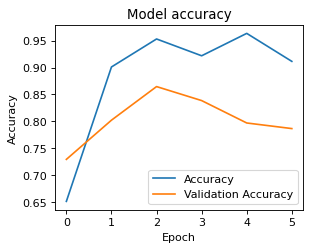

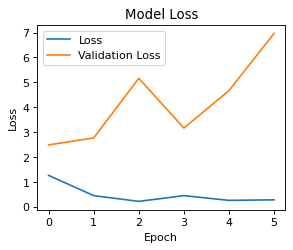

57/57 [==============================] - 142s 3s/step - loss: 8.6198 - accuracy: 0.7380 - f1_m: 0.7378 - precision_m: 0.7425 - recall_m: 0.7332


,Loss,Accuracy,F1,Precision,Recall
0,8.619792,0.737996,0.737809,0.742528,0.733221


Xception_All.h5 Time 258.0501765410004


In [16]:
from tensorflow.keras.applications import Xception
model_h2t = Xception(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )
for layer in model_h2t.layers:
    layer.trainable = True

output_xcp_all = get_k_fold_results(model_h2t,200,10,5,"Xception_All.h5")

In [17]:
output_xcp_all

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,5.400187,0.606828,0.544259,0.723627,0.509597
std,2.983405,0.175017,0.262871,0.166915,0.279381
min,1.906575,0.396892,0.141177,0.532697,0.077678
25%,3.601573,0.505690,0.489507,0.575691,0.453515
50%,4.480899,0.564807,0.537574,0.742528,0.504747
75%,8.392098,0.737996,0.737809,0.855706,0.733221
max,8.619792,0.828754,0.815230,0.911514,0.778826


## Last two layers fine tune

0 input_5 -- False
1 block1_conv1 -- False
2 block1_conv1_bn -- False
3 block1_conv1_act -- False
4 block1_conv2 -- False
5 block1_conv2_bn -- False
6 block1_conv2_act -- False
7 block2_sepconv1 -- False
8 block2_sepconv1_bn -- False
9 block2_sepconv2_act -- False
10 block2_sepconv2 -- False
11 block2_sepconv2_bn -- False
12 conv2d_4 -- False
13 block2_pool -- False
14 batch_normalization_4 -- False
15 add_12 -- False
16 block3_sepconv1_act -- False
17 block3_sepconv1 -- False
18 block3_sepconv1_bn -- False
19 block3_sepconv2_act -- False
20 block3_sepconv2 -- False
21 block3_sepconv2_bn -- False
22 conv2d_5 -- False
23 block3_pool -- False
24 batch_normalization_5 -- False
25 add_13 -- False
26 block4_sepconv1_act -- False
27 block4_sepconv1 -- False
28 block4_sepconv1_bn -- False
29 block4_sepconv2_act -- False
30 block4_sepconv2 -- False
31 block4_sepconv2_bn -- False
32 conv2d_6 -- False
33 block4_pool -- False
34 batch_normalization_6 -- False
35 add_14 -- False
36 block5_sepconv1

/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.9431 - accuracy: 0.3750 - f1_m: 0.2482 - precision_m: 0.5067 - recall_m: 0.1667 - val_loss: 1.5727 - val_accuracy: 0.4896 - val_f1_m: 0.5029 - val_precision_m: 0.7446 - val_recall_m: 0.3802
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.0198 - accuracy: 0.7604 - f1_m: 0.6057 - precision_m: 0.8770 - recall_m: 0.4635 - val_loss: 1.0145 - val_accuracy: 0.6823 - val_f1_m: 0.6255 - val_precision_m: 0.7965 - val_recall_m: 0.5156
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 0.8272 - accuracy: 0.7760 - f1_m: 0.6775 - precision_m: 0.8412 - recall_m: 0.5677 - val_loss: 1.0703 - val_accuracy: 0.6510 - val_f1_m: 0.6660 - val_precision_m: 0.7867 - val_recall_m: 0.5781
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.5980 - accuracy: 0.8698 - f1_m: 0.7903 - precision_m: 0.9227 - recall_m: 0.6927 - val_loss: 1.3460 - val_accuracy: 0.6354 - val_f1_m: 0.6209 - val_precision_

3/3 [==============================] - 3s 1s/step - loss: 0.3230 - accuracy: 0.9479 - f1_m: 0.8959 - precision_m: 0.9631 - recall_m: 0.8385 - val_loss: 0.7836 - val_accuracy: 0.8125 - val_f1_m: 0.8149 - val_precision_m: 0.8787 - val_recall_m: 0.7604
Epoch 12/50
3/3 [==============================] - 3s 1s/step - loss: 0.4924 - accuracy: 0.8802 - f1_m: 0.8386 - precision_m: 0.9202 - recall_m: 0.7708 - val_loss: 0.7162 - val_accuracy: 0.7969 - val_f1_m: 0.7864 - val_precision_m: 0.8537 - val_recall_m: 0.7292
Epoch 13/50
3/3 [==============================] - 3s 1s/step - loss: 0.3852 - accuracy: 0.9010 - f1_m: 0.8737 - precision_m: 0.9194 - recall_m: 0.8333 - val_loss: 0.8067 - val_accuracy: 0.7969 - val_f1_m: 0.7810 - val_precision_m: 0.8341 - val_recall_m: 0.7344
Epoch 14/50
3/3 [==============================] - 3s 1s/step - loss: 0.3532 - accuracy: 0.9062 - f1_m: 0.8699 - precision_m: 0.9443 - recall_m: 0.8073 - val_loss: 0.6461 - val_accuracy: 0.8438 - val_f1_m: 0.8215 - val_precisi

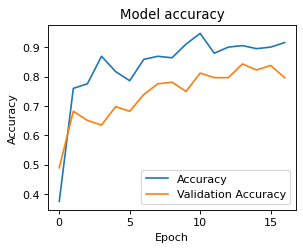

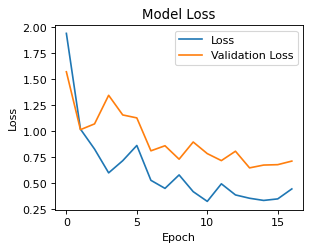

57/57 [==============================] - 16s 276ms/step - loss: 0.6928 - accuracy: 0.8246 - f1_m: 0.8092 - precision_m: 0.8616 - recall_m: 0.7637


,Loss,Accuracy,F1,Precision,Recall
0,0.692821,0.824591,0.809232,0.861628,0.763677


====== K Fold Validation step => 1 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.9907 - accuracy: 0.3906 - f1_m: 0.2112 - precision_m: 0.4056 - recall_m: 0.1458 - val_loss: 1.5852 - val_accuracy: 0.4948 - val_f1_m: 0.3702 - val_precision_m: 0.6430 - val_recall_m: 0.2604
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.0341 - accuracy: 0.7292 - f1_m: 0.5584 - precision_m: 0.8647 - recall_m: 0.4167 - val_loss: 1.1770 - val_accuracy: 0.6354 - val_f1_m: 0.5590 - val_precision_m: 0.7587 - val_recall_m: 0.4427
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 0.8407 - accuracy: 0.7604 - f1_m: 0.7036 - precision_m: 0.8634 - recall_m: 0.5938 - val_loss: 0.8285 - val_accuracy: 0.7344 - val_f1_m: 0.6948 - val_precision_m: 0.8192 - val_recall_m: 0.6042
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.6488 - accuracy: 0.8385 - f1_m: 0.7459 - precision_m: 0.8740 - recall_m: 0.6510 - val_loss: 0.9835 - val_accuracy: 0.7448 - val_f1_m: 0.6580 - val_precision_

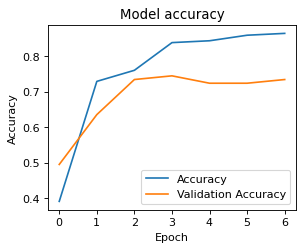

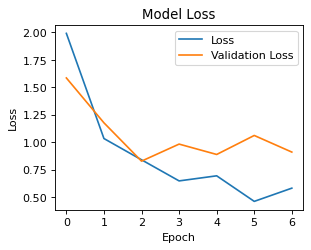

57/57 [==============================] - 15s 269ms/step - loss: 0.9305 - accuracy: 0.7519 - f1_m: 0.7287 - precision_m: 0.8174 - recall_m: 0.6583


,Loss,Accuracy,F1,Precision,Recall
0,0.930547,0.751873,0.728695,0.817446,0.658313


====== K Fold Validation step => 2 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 1.9646 - accuracy: 0.3750 - f1_m: 0.2228 - precision_m: 0.4980 - recall_m: 0.1458 - val_loss: 1.4905 - val_accuracy: 0.5677 - val_f1_m: 0.5283 - val_precision_m: 0.7557 - val_recall_m: 0.4062
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.0846 - accuracy: 0.7083 - f1_m: 0.5497 - precision_m: 0.7911 - recall_m: 0.4219 - val_loss: 1.1367 - val_accuracy: 0.5938 - val_f1_m: 0.5527 - val_precision_m: 0.7019 - val_recall_m: 0.4583
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9038 - accuracy: 0.7344 - f1_m: 0.6431 - precision_m: 0.8277 - recall_m: 0.5260 - val_loss: 0.9267 - val_accuracy: 0.7344 - val_f1_m: 0.6663 - val_precision_m: 0.7979 - val_recall_m: 0.5729
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.5961 - accuracy: 0.8438 - f1_m: 0.7666 - precision_m: 0.9124 - recall_m: 0.6615 - val_loss: 0.9259 - val_accuracy: 0.7500 - val_f1_m: 0.7095 - val_precision_

3/3 [==============================] - 3s 1s/step - loss: 0.3663 - accuracy: 0.8750 - f1_m: 0.8849 - precision_m: 0.9327 - recall_m: 0.8438 - val_loss: 1.0739 - val_accuracy: 0.8229 - val_f1_m: 0.7943 - val_precision_m: 0.8509 - val_recall_m: 0.7448
Epoch 12/50
3/3 [==============================] - 3s 1s/step - loss: 0.4416 - accuracy: 0.8542 - f1_m: 0.8490 - precision_m: 0.9103 - recall_m: 0.7969 - val_loss: 0.8105 - val_accuracy: 0.8385 - val_f1_m: 0.7946 - val_precision_m: 0.8516 - val_recall_m: 0.7448
Epoch 13/50
3/3 [==============================] - 3s 1s/step - loss: 0.4227 - accuracy: 0.9062 - f1_m: 0.8776 - precision_m: 0.9205 - recall_m: 0.8385 - val_loss: 0.6880 - val_accuracy: 0.8385 - val_f1_m: 0.8168 - val_precision_m: 0.8692 - val_recall_m: 0.7708
Epoch 14/50
3/3 [==============================] - 3s 1s/step - loss: 0.4245 - accuracy: 0.8958 - f1_m: 0.8808 - precision_m: 0.9153 - recall_m: 0.8490 - val_loss: 0.8944 - val_accuracy: 0.7969 - val_f1_m: 0.7978 - val_precisi

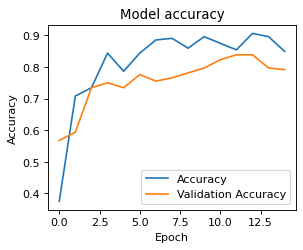

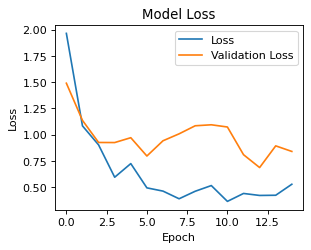

57/57 [==============================] - 17s 295ms/step - loss: 0.9049 - accuracy: 0.8107 - f1_m: 0.7884 - precision_m: 0.8413 - recall_m: 0.7424


,Loss,Accuracy,F1,Precision,Recall
0,0.90494,0.810713,0.78836,0.841337,0.74244


====== K Fold Validation step => 3 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 1.8784 - accuracy: 0.3802 - f1_m: 0.2360 - precision_m: 0.4436 - recall_m: 0.1615 - val_loss: 1.5370 - val_accuracy: 0.5521 - val_f1_m: 0.4373 - val_precision_m: 0.7643 - val_recall_m: 0.3073
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.0456 - accuracy: 0.7031 - f1_m: 0.6243 - precision_m: 0.9178 - recall_m: 0.4740 - val_loss: 1.1039 - val_accuracy: 0.7292 - val_f1_m: 0.6054 - val_precision_m: 0.8221 - val_recall_m: 0.4792
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.8334 - accuracy: 0.7742 - f1_m: 0.6297 - precision_m: 0.8632 - recall_m: 0.4971 - val_loss: 1.4791 - val_accuracy: 0.6823 - val_f1_m: 0.6131 - val_precision_m: 0.7380 - val_recall_m: 0.5260
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.7631 - accuracy: 0.8021 - f1_m: 0.7077 - precision_m: 0.8652 - recall_m: 0.5990 - val_loss: 1.0777 - val_accuracy: 0.6823 - val_f1_m: 0.6383 - val_precision_

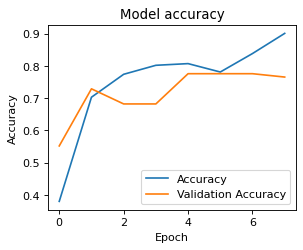

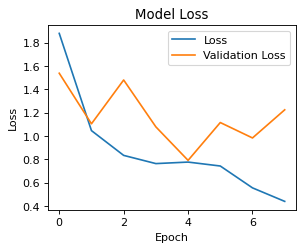

57/57 [==============================] - 16s 283ms/step - loss: 0.9442 - accuracy: 0.7893 - f1_m: 0.7555 - precision_m: 0.8287 - recall_m: 0.6951


,Loss,Accuracy,F1,Precision,Recall
0,0.944202,0.789342,0.755451,0.828726,0.695118


====== K Fold Validation step => 4 =======
Found 14427 images belonging to 10 classes.
Found 3603 images belonging to 10 classes.


/var/folders/ts/d09tttfn5lv78xjnbv8vqn_r0000gn/T/ipykernel_6078/557135215.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=3,generator=train_generator, validation_data=validation_generator, validation_steps=3,epochs=epochs, callbacks=[checkpoint,early])
/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/50


/Users/amankesarwani/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 3s 1s/step - loss: 2.0402 - accuracy: 0.2917 - f1_m: 0.1824 - precision_m: 0.3909 - recall_m: 0.1198 - val_loss: 1.6321 - val_accuracy: 0.5052 - val_f1_m: 0.4299 - val_precision_m: 0.6982 - val_recall_m: 0.3125
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 1.2201 - accuracy: 0.6771 - f1_m: 0.5825 - precision_m: 0.7996 - recall_m: 0.4583 - val_loss: 1.1067 - val_accuracy: 0.6615 - val_f1_m: 0.6520 - val_precision_m: 0.7984 - val_recall_m: 0.5521
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 1.0168 - accuracy: 0.7292 - f1_m: 0.6411 - precision_m: 0.8233 - recall_m: 0.5260 - val_loss: 0.9343 - val_accuracy: 0.7240 - val_f1_m: 0.6455 - val_precision_m: 0.8004 - val_recall_m: 0.5417
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.6101 - accuracy: 0.8281 - f1_m: 0.7621 - precision_m: 0.9023 - recall_m: 0.6615 - val_loss: 1.2353 - val_accuracy: 0.6927 - val_f1_m: 0.6480 - val_precision_

3/3 [==============================] - 3s 1s/step - loss: 0.5293 - accuracy: 0.8490 - f1_m: 0.8415 - precision_m: 0.8850 - recall_m: 0.8021 - val_loss: 0.6042 - val_accuracy: 0.8385 - val_f1_m: 0.7840 - val_precision_m: 0.8625 - val_recall_m: 0.7188
Epoch 12/50
3/3 [==============================] - 4s 1s/step - loss: 0.4105 - accuracy: 0.8958 - f1_m: 0.8791 - precision_m: 0.9314 - recall_m: 0.8333 - val_loss: 0.7657 - val_accuracy: 0.8021 - val_f1_m: 0.7787 - val_precision_m: 0.8432 - val_recall_m: 0.7240
Epoch 13/50
3/3 [==============================] - 4s 1s/step - loss: 0.4667 - accuracy: 0.9062 - f1_m: 0.8675 - precision_m: 0.9328 - recall_m: 0.8125 - val_loss: 0.6754 - val_accuracy: 0.8021 - val_f1_m: 0.8186 - val_precision_m: 0.8800 - val_recall_m: 0.7656
Epoch 14/50
3/3 [==============================] - 4s 1s/step - loss: 0.3717 - accuracy: 0.9062 - f1_m: 0.8732 - precision_m: 0.9392 - recall_m: 0.8177 - val_loss: 0.4903 - val_accuracy: 0.8750 - val_f1_m: 0.8460 - val_precisi

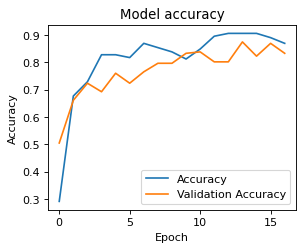

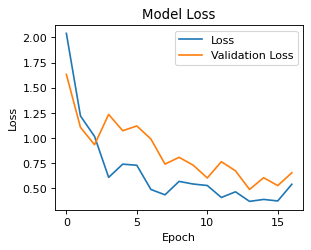

57/57 [==============================] - 17s 288ms/step - loss: 0.6253 - accuracy: 0.8540 - f1_m: 0.8290 - precision_m: 0.8856 - recall_m: 0.7798


,Loss,Accuracy,F1,Precision,Recall
0,0.625302,0.854011,0.82898,0.885592,0.779822


Xception_FineTune.h5 Time 305.915541417


In [17]:
from tensorflow.keras.applications import Xception
model_last2 = Xception(weights='imagenet', include_top=False, input_shape = (img_width, img_height,3) )

for layer in model_last2.layers[:-2]:
    layer.trainable=False

for i, layer in enumerate(model_last2.layers):
    print(i,layer.name, "--",layer.trainable)

output_xcp_last2 = get_k_fold_results(model_last2,50,10,5,"Xception_FineTune.h5")

In [18]:
output_xcp_last2

,Loss,Accuracy,F1,Precision,Recall
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.819562,0.806106,0.782144,0.846946,0.727874
std,0.149116,0.038340,0.040421,0.027124,0.050260
min,0.625302,0.751873,0.728695,0.817446,0.658313
25%,0.692821,0.789342,0.755451,0.828726,0.695118
50%,0.904940,0.810713,0.788360,0.841337,0.742440
75%,0.930547,0.824591,0.809232,0.861628,0.763677
max,0.944202,0.854011,0.828980,0.885592,0.779822
